<a href="https://colab.research.google.com/github/Mike4lpha/Formation-Evaluation/blob/main/FormationEvaluationNew.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction:


### Problem Statement

Identifying subsurface lithologies or rock types is essential for all geoscientists and petrophysicists in order to explore our subsurface resources, particularly in the oil and gas industry. Lithology refers to the type of rock that forms the subsurface, and it is classified into, for instance, sandstone, claystone, marl, limestone, and dolomite. Several subsurface data can be used to identify lithologies, such as wireline logs petrophysical data. However, it is often a tedious, repetitive and time-consuming task. This project will predict lithology from petrophysical logs using machine learning techniques (classification) and add to the solution of these problems since these logs are direct proxies of lithology.

### Wireline Log Datasets

The data consist of 118 wells dataset spans through the South and North Viking graben and penetrates a highly variable geology from the Permian evaporites in the south the the deeply buried Brent delta facies in the North. An investigation of the provided training data clearly shows that the lithologic record offshore Norway is dominated by shales and shaly sediments. This is followed by sandstones, limestones, marls and the tufts.

The provided dataset contains well logs, interpreted lithofacies and lithostratigraphy for 90+ released wells from offshore Norway. The well logs include the well name (WELL), the measured depth, x,y,z location for the wireline measurement as well as the well logs CALI, RDEP, RHOB, DHRO, SGR, GR, RMED, RMIC, NPHI, PEF, RSHA, DTC, SP, BS, ROP, DTS, DCAL, MUDWEIGHT. An explanation of the abbreviations is shown in the figure below.

### Logs Interpretations Description

The data contains the metadata columns:

* WELL: Well Name
* DEPTH_MD: Measured Depth
* X_LOC: UTM X Coordinate
* Y_LOC: UTM Y Coordinate
* Z_LOC: DEPTH
* GROUP: NPD lithostratigraphy group
* FORMATION: NPD lithostratgraphy formation

The data contains the well log curves:

* BS: Bit Size
* CALI: Caliper Log
* DCAL: Differential Caliper log
* RDEP: Deep Resistivity
* RMED: Medium Resistivity
* RSHA: Shallow Resistivity
* RXO: Flushed Zone Resistivity
* RHOB: Bulk Density
* GR: Raw Gamma Ray
* SGR: Spectral Gamma Ray
* SP: Spontaneous Potential
* ROP: Rate of Penetration
* ROPA: Average Rate of Penetration
* NPHI: Neutron Porosity
* PEF: Photoelectric Absorption Factor
* RMIC: Micro Resistivity
* DTS: Sonic (Shear Wave)
* DTC: Sonic (Compressional Wave)
* DRHO: Density Correction Log
* MUDWEIGHT: Weight of Drilling Fluid

## The Lithology Column

The LITHOLOGY column contains the interpretation. Each number corresponds to a lithology class, given by the following list:

In [ ]:
lithology_keys = {30000: 'Sandstone',
                 65030: 'Sandstone/Shale',
                 65000: 'Shale',
                 80000: 'Marl',
                 74000: 'Dolomite',
                 70000: 'Limestone',
                 70032: 'Chalk',
                 88000: 'Halite',
                 86000: 'Anhydrite',
                 99000: 'Tuff',
                 90000: 'Coal',
                 93000: 'Basement'}

## Installing Libraries:

In [100]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0


In [101]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [102]:
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

## Loading The Dataset:

In [103]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [104]:
df_train=pd.read_csv('/content/drive/MyDrive/LITHOLOGY/train.csv',sep=';')
df_test=pd.read_csv('/content/drive/MyDrive/LITHOLOGY/test.csv',sep=';')
df_hiddentest=pd.read_csv('/content/drive/MyDrive/LITHOLOGY/hidden_test.csv',sep=';')

## Understanding The Dataset

In [66]:
df_train.shape

(1170511, 29)

In [ ]:
df_train.sample(10)

,WELL,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,GROUP,FORMATION,CALI,RSHA,RMED,...,ROP,DTS,DCAL,DRHO,MUDWEIGHT,RMIC,ROPA,RXO,FORCE_2020_LITHOFACIES_LITHOLOGY,FORCE_2020_LITHOFACIES_CONFIDENCE
304908,25/3-1,3237.408000,487280.12500,6643976.0,-3214.802979,VESTLAND GP.,Sleipner Fm.,8.787761,6.345156,22.015554,...,4.544476,NaN,0.294460,-0.000328,1.917222,7.104751,NaN,7.207767,90000,1.0
1005103,35/11-12,1618.986000,520561.34375,6777355.0,-1594.940796,HORDALAND GP.,Utsira Fm.,NaN,NaN,0.505578,...,61.729252,NaN,NaN,NaN,NaN,NaN,NaN,NaN,65000,3.0
927665,34/8-1,1418.577023,469662.68750,6803718.5,-1395.537476,HORDALAND GP.,Utsira Fm.,18.181814,NaN,0.972155,...,NaN,NaN,NaN,0.025483,NaN,NaN,NaN,NaN,65000,1.0
368379,25/6-1,2597.536000,488709.03125,6598747.5,-2571.415527,DUNLIN GP.,Skagerrak Fm.,12.824594,2.060352,1.701048,...,2.078208,NaN,0.574592,0.035291,0.131809,NaN,NaN,NaN,65030,1.0
659365,31/4-5,2391.996796,503113.65625,6713727.0,-2366.117676,DUNLIN GP.,Drake Fm.,12.531300,NaN,3.048390,...,NaN,NaN,NaN,0.017495,NaN,NaN,NaN,NaN,65000,1.0
967810,35/11-1,1796.633123,535640.25000,6783534.5,-1771.495483,SHETLAND GP.,Vaale Fm.,18.473150,NaN,1.516044,...,NaN,NaN,NaN,-0.006071,NaN,NaN,NaN,NaN,65000,1.0
267284,25/2-7,844.818001,479888.06250,6641111.0,-819.806763,NORDLAND GP.,NaN,24.015999,0.525481,0.525481,...,1.400356,NaN,NaN,-0.003115,0.127016,NaN,NaN,NaN,90000,1.0
913459,34/7-21,1317.942000,450300.78125,6795999.0,-1291.899414,HORDALAND GP.,Utsira Fm.,18.357307,NaN,0.914796,...,NaN,NaN,NaN,-0.008373,NaN,NaN,NaN,NaN,65000,1.0
843440,34/12-1,3847.757584,499931.31250,6787698.5,-3823.218506,SHETLAND GP.,Svarte Fm.,12.337362,2.553271,2.138507,...,28.243008,169.332367,NaN,0.001251,NaN,NaN,28.280001,NaN,70000,1.0
424588,25/8-7,1179.343115,475895.84375,6593126.5,-1154.343140,HORDALAND GP.,Utsira Fm.,12.425898,1.163812,1.173930,...,135.491425,NaN,0.175894,NaN,0.152180,0.956251,NaN,NaN,65000,1.0


In [ ]:
df_train.describe()

,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,CALI,RSHA,RMED,RDEP,RHOB,GR,...,ROP,DTS,DCAL,DRHO,MUDWEIGHT,RMIC,ROPA,RXO,FORCE_2020_LITHOFACIES_LITHOLOGY,FORCE_2020_LITHOFACIES_CONFIDENCE
count,1.170511e+06,1.159736e+06,1.159736e+06,1.159736e+06,1.082634e+06,630650.000000,1.131518e+06,1.159496e+06,1.009242e+06,1.170511e+06,...,535071.000000,174613.000000,298833.000000,987857.000000,316151.000000,176160.000000,192325.000000,327427.000000,1.170511e+06,1.170332e+06
mean,2.184087e+03,4.856310e+05,6.681276e+06,-2.138527e+03,1.318568e+01,10.694664,4.986978e+00,1.069103e+01,2.284987e+00,7.091370e+01,...,137.367965,204.655019,1.223849,0.012196,1.216329,7.796809,23.505069,-95.779496,6.138598e+04,1.164258e+00
std,9.971821e+02,3.455641e+04,1.281524e+05,9.709426e+02,3.798907e+00,100.642597,5.467269e+01,1.139480e+02,2.532835e-01,3.423149e+01,...,1539.383558,71.068461,54.372859,7.477798,10.180834,89.741807,22.632800,348.980030,1.389170e+04,4.451180e-01
min,1.360860e+02,4.268988e+05,6.406641e+06,-5.395563e+03,2.344000e+00,0.000100,-8.418695e-03,3.170056e-02,7.209712e-01,1.092843e-01,...,-0.117977,69.163177,-12.215459,-7429.338867,0.125818,0.056586,-999.250122,-999.900024,3.000000e+04,1.000000e+00
25%,1.418597e+03,4.547996e+05,6.591327e+06,-2.811502e+03,9.429712e+00,0.854120,9.140862e-01,9.102396e-01,2.092203e+00,4.762722e+01,...,5.628000,155.936707,0.148438,-0.009253,0.143792,0.891272,11.281895,0.687681,6.500000e+04,1.000000e+00
50%,2.076605e+03,4.769203e+05,6.737311e+06,-2.042785e+03,1.255575e+01,1.399020,1.443584e+00,1.439000e+00,2.321228e+00,6.836763e+01,...,17.799999,188.200653,0.557320,0.001752,0.155774,1.967156,20.131153,1.366672,6.500000e+04,1.000000e+00
75%,2.864393e+03,5.201532e+05,6.784886e+06,-1.391866e+03,1.671075e+01,3.099348,2.680930e+00,2.557220e+00,2.488580e+00,8.903551e+01,...,34.812794,224.645081,1.299655,0.021702,1.168307,5.084564,31.138481,3.420790,6.500000e+04,1.000000e+00
max,5.436632e+03,5.726328e+05,6.856661e+06,-1.110860e+02,2.827900e+01,2193.904541,1.988616e+03,1.999887e+03,3.457820e+00,1.076964e+03,...,47015.125000,676.578125,10011.422852,2.836938,185.730927,10000.000000,742.797852,35930.671875,9.900000e+04,3.000000e+00


In [ ]:
df_test.sample(10)

,WELL,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,GROUP,FORMATION,CALI,RSHA,RMED,...,SP,BS,ROP,DTS,DCAL,DRHO,MUDWEIGHT,RMIC,ROPA,RXO
87694,34/10-16 R,3018.168008,455790.34375,6773609.5,-2995.326904,VIKING GP.,Draupne Fm.,18.842268,1.900297,1.685447,...,72.871719,NaN,NaN,NaN,NaN,-0.011152,NaN,NaN,NaN,1.900297
31858,25/11-24,1800.083200,462262.25000,6551906.0,-1773.991089,ROGALAND GP.,Heimdal Fm.,8.659056,NaN,0.329574,...,NaN,8.500000,11.752691,232.781403,0.159055,-0.008273,NaN,0.179000,11.068234,NaN
104488,34/3-3 A,3771.353976,485663.90625,6852438.5,-3260.196045,SHETLAND GP.,Kyrre Fm.,12.480385,NaN,1.899154,...,NaN,12.250001,25.535868,193.105606,NaN,0.085539,NaN,NaN,40.028114,NaN
45302,29/3-1,722.978001,442442.37500,6759399.0,-697.972290,NORDLAND GP.,Utsira Fm.,18.664406,NaN,1.117837,...,63.878929,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25283,25/10-10,1850.670400,459853.40625,6560993.0,-1810.553101,ROGALAND GP.,Sele Fm.,12.726281,0.606360,0.596029,...,NaN,12.250001,13.354552,NaN,0.476281,0.038281,NaN,NaN,19.313747,NaN
135108,35/9-8,2930.877600,536233.37500,6794887.5,-2906.548828,VIKING GP.,Heather Fm.,8.550877,NaN,14.763415,...,NaN,8.500000,19.307396,147.219818,NaN,0.003391,NaN,13.516093,25.337755,NaN
85059,34/10-16 R,2617.648008,455770.31250,6773613.5,-2595.372070,SHETLAND GP.,Kyrre Fm.,13.478932,1.360355,1.667435,...,77.147751,NaN,NaN,NaN,NaN,0.095041,NaN,NaN,NaN,1.360355
132771,35/9-8,2575.653600,536236.25000,6794890.5,-2551.360840,SHETLAND GP.,Tryggvason Fm.,8.778839,NaN,4.337900,...,NaN,8.500000,13.803486,163.898361,NaN,-0.015039,NaN,4.529138,10.244725,NaN
39302,25/5-3,1990.587190,479087.12500,6605454.5,-1968.479248,HORDALAND GP.,Grid Fm.,12.410804,NaN,0.841439,...,-1.963630,12.250001,NaN,NaN,NaN,0.033847,NaN,NaN,NaN,NaN
84754,34/10-16 R,2571.288008,455768.50000,6773613.5,-2549.047852,SHETLAND GP.,Kyrre Fm.,14.286215,0.932007,1.491049,...,75.528763,NaN,NaN,NaN,NaN,0.048132,NaN,NaN,NaN,0.932007


In [ ]:
df_hiddentest.sample(10)

,WELL,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,GROUP,FORMATION,CALI,RSHA,RMED,...,ROP,DTS,DCAL,DRHO,MUDWEIGHT,RMIC,ROPA,RXO,FORCE_2020_LITHOFACIES_LITHOLOGY,FORCE_2020_LITHOFACIES_CONFIDENCE
105570,35/11-5,2821.115997,521493.28125,6771818.0,-2795.721436,VIKING GP.,Draupne Fm.,13.454714,10.422291,7.388017,...,NaN,NaN,NaN,-0.014333,NaN,NaN,NaN,NaN,65000,1.0
8063,15/9-23,2755.864000,433923.03125,6459987.0,-2730.602783,SHETLAND GP.,Hod Fm.,12.274160,NaN,2.039543,...,67.972862,144.460190,0.024160,0.032756,NaN,NaN,52.559353,NaN,70000,2.0
121941,35/9-7,2904.746800,536099.56250,6793026.0,-2875.091309,VIKING GP.,Heather Fm.,8.576715,NaN,5.752036,...,9.485752,168.799896,NaN,-0.027600,NaN,6.292145,9.111671,NaN,65030,1.0
31241,16/7-6,2405.974400,443849.37500,6458307.5,-2380.780029,SHETLAND GP.,Tor Fm.,11.908603,6.412156,5.918077,...,8.923741,120.806099,-0.341395,-0.043693,NaN,5.469812,NaN,NaN,70032,1.0
119231,35/9-7,2492.826800,536111.75000,6793043.0,-2463.749023,SHETLAND GP.,Tryggvason Fm.,8.636201,NaN,3.664441,...,10.912335,171.236237,NaN,-0.001626,NaN,4.231061,9.256807,NaN,65000,2.0
87281,34/3-2 S,3874.126800,490648.96875,6853314.0,-3840.425781,DUNLIN GP.,Drake Fm.,12.681535,NaN,3.019178,...,17.494312,182.978302,NaN,NaN,NaN,NaN,14.915275,NaN,65000,3.0
10455,15/9-23,3120.360000,433930.65625,6459979.0,-3094.930664,VESTLAND GP.,Sleipner Fm.,8.504270,NaN,1.083858,...,105.507210,286.865417,0.004269,0.032201,NaN,NaN,74.634445,NaN,30000,1.0
119274,35/9-7,2499.362800,536111.68750,6793042.5,-2470.282471,SHETLAND GP.,Tryggvason Fm.,8.643664,NaN,3.508618,...,6.196240,175.650696,NaN,-0.004159,NaN,4.182328,10.835793,NaN,65000,2.0
87746,34/3-2 S,3959.702800,490649.21875,6853314.0,-3926.001221,DUNLIN GP.,Drake Fm.,8.538359,NaN,2.497221,...,6.575916,178.093948,NaN,0.025541,NaN,NaN,6.364718,NaN,80000,2.0
65052,31/2-10,1068.024000,526911.25000,6740121.5,-1042.964600,HORDALAND GP.,NaN,18.576166,NaN,1.034747,...,NaN,NaN,NaN,0.010844,NaN,NaN,NaN,NaN,65000,1.0


In [ ]:
df_hiddentest.describe()

,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,CALI,RSHA,RMED,RDEP,RHOB,GR,...,ROP,DTS,DCAL,DRHO,MUDWEIGHT,RMIC,ROPA,RXO,FORCE_2020_LITHOFACIES_LITHOLOGY,FORCE_2020_LITHOFACIES_CONFIDENCE
count,122397.000000,122386.000000,1.223860e+05,122386.000000,118954.000000,25683.000000,112580.000000,122386.000000,112869.000000,122397.000000,...,91150.000000,72871.000000,43104.000000,112267.000000,0.0,15181.000000,64221.000000,8894.000000,122397.000000,122377.000000
mean,2209.918995,495031.999867,6.641592e+06,-2175.312134,12.878327,22.741097,3.428125,23.664096,2.325457,72.125599,...,36.002535,238.065539,0.244774,0.016727,NaN,3.089212,35.830181,153.622474,63642.854400,1.122090
std,830.939854,34686.859130,1.486340e+05,825.338356,3.195471,171.547958,31.791279,96.279477,0.223338,35.301383,...,42.339898,93.206098,0.771045,0.098004,NaN,9.965275,39.459786,501.615305,13772.405436,0.370172
min,443.379997,433906.750000,6.458300e+06,-4286.082520,8.025192,0.119106,0.158995,0.037163,1.127937,1.132300,...,0.000000,86.628220,-5.500000,-1.453413,NaN,0.132760,0.115860,0.120551,30000.000000,1.000000
25%,1589.516002,452405.968750,6.495507e+06,-2738.910767,12.005362,0.776829,0.850705,0.870180,2.176974,49.684471,...,14.561207,158.404366,0.009263,-0.005220,NaN,0.901667,14.891059,0.577777,65000.000000,1.000000
50%,2193.864800,515574.437500,6.740118e+06,-2156.599853,12.453753,1.287566,1.337297,1.381397,2.370102,74.382141,...,24.080531,213.502136,0.172958,0.015108,NaN,1.474687,24.024317,1.204135,65000.000000,1.000000
75%,2791.376800,521504.781250,6.771839e+06,-1563.775421,13.379490,3.672304,2.433031,2.923758,2.499295,94.324402,...,39.772709,324.204788,0.426309,0.052338,NaN,3.143365,39.383507,2.412848,65030.000000,1.000000
max,4319.790800,536112.500000,6.853475e+06,-420.046387,23.093700,1999.717041,1573.656006,1755.531006,3.353153,1141.292114,...,694.254578,562.037109,8.380077,0.675181,NaN,621.158386,439.485748,2030.926148,99000.000000,3.000000


In [105]:
df_train['FORCE_2020_LITHOFACIES_LITHOLOGY'].unique()
df_train.rename(columns={'FORCE_2020_LITHOFACIES_LITHOLOGY': 'Lithology'}, inplace=True)
df_train.rename(columns={'FORCE_2020_LITHOFACIES_CONFIDENCE': 'Confidence'}, inplace=True)
df_hiddentest['FORCE_2020_LITHOFACIES_LITHOLOGY'].unique()
df_hiddentest.rename(columns={'FORCE_2020_LITHOFACIES_LITHOLOGY': 'Lithology'}, inplace=True)
df_hiddentest.rename(columns={'FORCE_2020_LITHOFACIES_CONFIDENCE': 'Confidence'}, inplace=True)

In [ ]:
df_train.sample(5)

,WELL,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,GROUP,FORMATION,CALI,RSHA,RMED,...,ROP,DTS,DCAL,DRHO,MUDWEIGHT,RMIC,ROPA,RXO,Lithology,Confidence
480775,29/6-1,3079.537001,444568.50000,6711925.5,-3054.175293,SHETLAND GP.,Kyrre Fm.,14.580204,NaN,2.113890,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,65000,1.0
741738,33/9-17,2009.297985,438459.34375,6814160.0,-1982.697144,SHETLAND GP.,Jorsalfare Fm.,9.873089,1.205474,1.133356,...,NaN,NaN,NaN,-0.007108,NaN,NaN,7.757986,1.248182,65000,1.0
338236,25/5-1,1482.600000,475848.71875,6621553.0,-1457.524170,HORDALAND GP.,Grid Fm.,17.453100,NaN,1.242792,...,1.957400,NaN,NaN,-0.005857,0.131809,NaN,NaN,NaN,65000,1.0
1142171,35/9-6 S,2737.928000,536941.25000,6804541.0,-2663.295166,SHETLAND GP.,Kyrre Fm.,12.160661,NaN,3.545988,...,NaN,NaN,NaN,0.028997,NaN,2.818538,8.579953,NaN,70000,1.0
441824,25/9-1,1564.126000,483534.40625,6590314.0,-1538.991943,HORDALAND GP.,Skade Fm.,12.130274,0.571845,0.574570,...,125.625343,NaN,NaN,NaN,0.152180,0.823230,NaN,0.575944,65000,1.0


In [ ]:
df_hiddentest.sample(5)

,WELL,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,GROUP,FORMATION,CALI,RSHA,RMED,...,ROP,DTS,DCAL,DRHO,MUDWEIGHT,RMIC,ROPA,RXO,Lithology,Confidence
46885,17/4-1,3324.494793,515574.43750,6495507.0,-3297.495117,ZECHSTEIN GP.,Smith Bank Fm.,12.021915,NaN,NaN,...,10.688412,NaN,NaN,NaN,NaN,NaN,NaN,NaN,88000,1.0
45147,17/4-1,3060.318793,515574.43750,6495507.0,-3033.319092,ZECHSTEIN GP.,Smith Bank Fm.,12.226502,NaN,NaN,...,8.430902,NaN,NaN,NaN,NaN,NaN,NaN,NaN,88000,1.0
61919,31/2-10,591.808000,526908.12500,6740119.5,-566.803955,NORDLAND GP.,NaN,15.389952,NaN,2.209767,...,NaN,NaN,NaN,0.009715,NaN,NaN,NaN,NaN,65000,1.0
117417,35/9-7,2217.098800,536111.68750,6793046.0,-2188.046631,SHETLAND GP.,Kyrre Fm.,12.307644,NaN,1.344314,...,9.758997,237.931168,NaN,0.110368,NaN,NaN,6.860341,NaN,65000,1.0
78921,34/3-2 S,2573.310800,490556.15625,6853467.5,-2554.714600,SHETLAND GP.,Kyrre Fm.,12.420021,NaN,1.051525,...,38.371517,NaN,NaN,-0.010128,NaN,NaN,25.425793,NaN,70000,1.0


In [7]:
dftype = pd.DataFrame(df_train.dtypes, columns=['Data_Type'])
dftype['Number_Unique'] = df_train.nunique()
dftype['Number_of_Nan'] = df_train.isna().sum()
dftype

,Data_Type,Number_Unique,Number_of_Nan
WELL,object,98,0
DEPTH_MD,float64,1146418,0
X_LOC,float64,166525,10775
Y_LOC,float64,17481,10775
Z_LOC,float64,1128126,10775
GROUP,object,14,1278
FORMATION,object,69,136994
CALI,float64,874208,87877
RSHA,float64,619225,539861
RMED,float64,1104594,38993


## Preparing Petrophysical Logs

In [106]:
lithology_keys = {30000: 'Sandstone',
                 65030: 'Sandstone/Shale',
                 65000: 'Shale',
                 80000: 'Marl',
                 74000: 'Dolomite',
                 70000: 'Limestone',
                 70032: 'Chalk',
                 88000: 'Halite',
                 86000: 'Anhydrite',
                 99000: 'Tuff',
                 90000: 'Coal',
                 93000: 'Basement'}

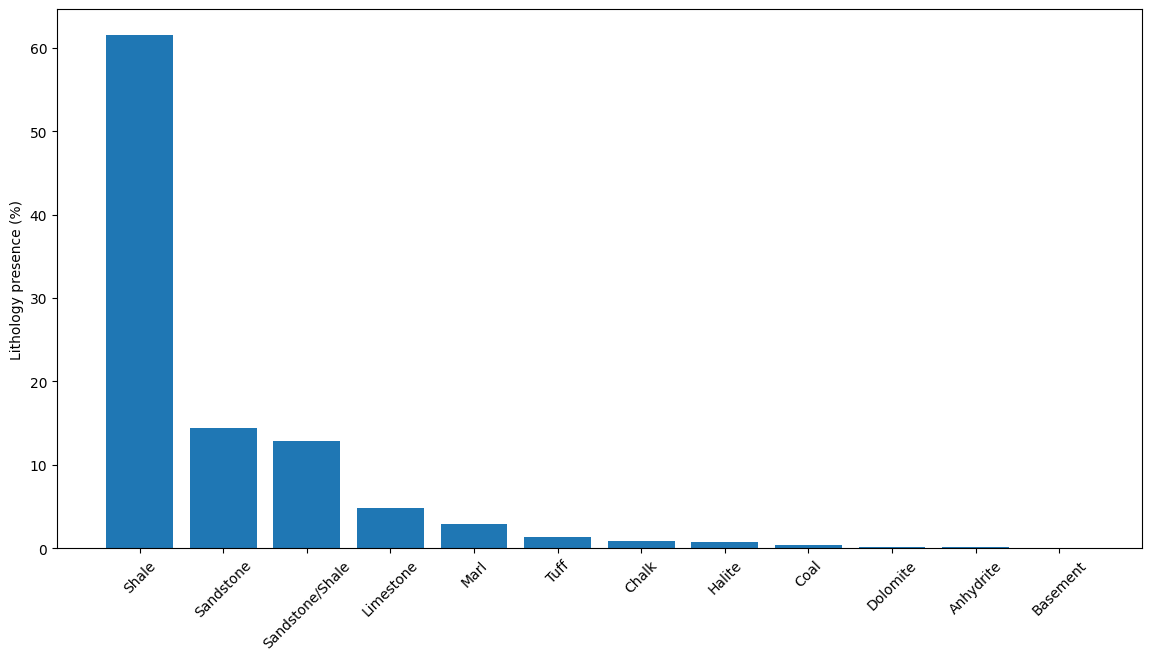

In [107]:
counts = df_train['Lithology'].value_counts()
names = []
percentage = []
N = df_train['Lithology'].shape[0]

for key, value in counts.items():
    names.append(lithology_keys[key])
    percentage.append((value / N) * 100)

fig, ax = plt.subplots(figsize=(14, 7))
ax.bar(x=np.arange(len(names)), height=percentage)
ax.set_xticks(np.arange(len(names)))
ax.set_xticklabels(names, rotation=45)
ax.set_ylabel(r'Lithology presence (%)')

plt.show()

In [108]:
df_train['Lithology'] = df_train['Lithology'].map(lithology_keys)
df_hiddentest['Lithology'] = df_hiddentest['Lithology'].map(lithology_keys)

In [71]:
wells = df_train['WELL'].unique()
wells

array(['15/9-13', '15/9-15', '15/9-17', '16/1-2', '16/1-6 A', '16/10-1',
       '16/10-2', '16/10-3', '16/10-5', '16/11-1 ST3', '16/2-11 A',
       '16/2-16', '16/2-6', '16/4-1', '16/5-3', '16/7-4', '16/7-5',
       '16/8-1', '17/11-1', '25/11-15', '25/11-19 S', '25/11-5',
       '25/2-13 T4', '25/2-14', '25/2-7', '25/3-1', '25/4-5', '25/5-1',
       '25/5-4', '25/6-1', '25/6-2', '25/6-3', '25/7-2', '25/8-5 S',
       '25/8-7', '25/9-1', '26/4-1', '29/6-1', '30/3-3', '30/3-5 S',
       '30/6-5', '31/2-1', '31/2-19 S', '31/2-7', '31/2-8', '31/2-9',
       '31/3-1', '31/3-2', '31/3-3', '31/3-4', '31/4-10', '31/4-5',
       '31/5-4 S', '31/6-5', '31/6-8', '32/2-1', '33/5-2', '33/6-3 S',
       '33/9-1', '33/9-17', '34/10-19', '34/10-21', '34/10-33',
       '34/10-35', '34/11-1', '34/11-2 S', '34/12-1', '34/2-4',
       '34/3-1 A', '34/4-10 R', '34/5-1 A', '34/5-1 S', '34/7-13',
       '34/7-20', '34/7-21', '34/8-1', '34/8-3', '34/8-7 R', '35/11-1',
       '35/11-10', '35/11-11', '35/11-12

In [ ]:
len(wells)

98

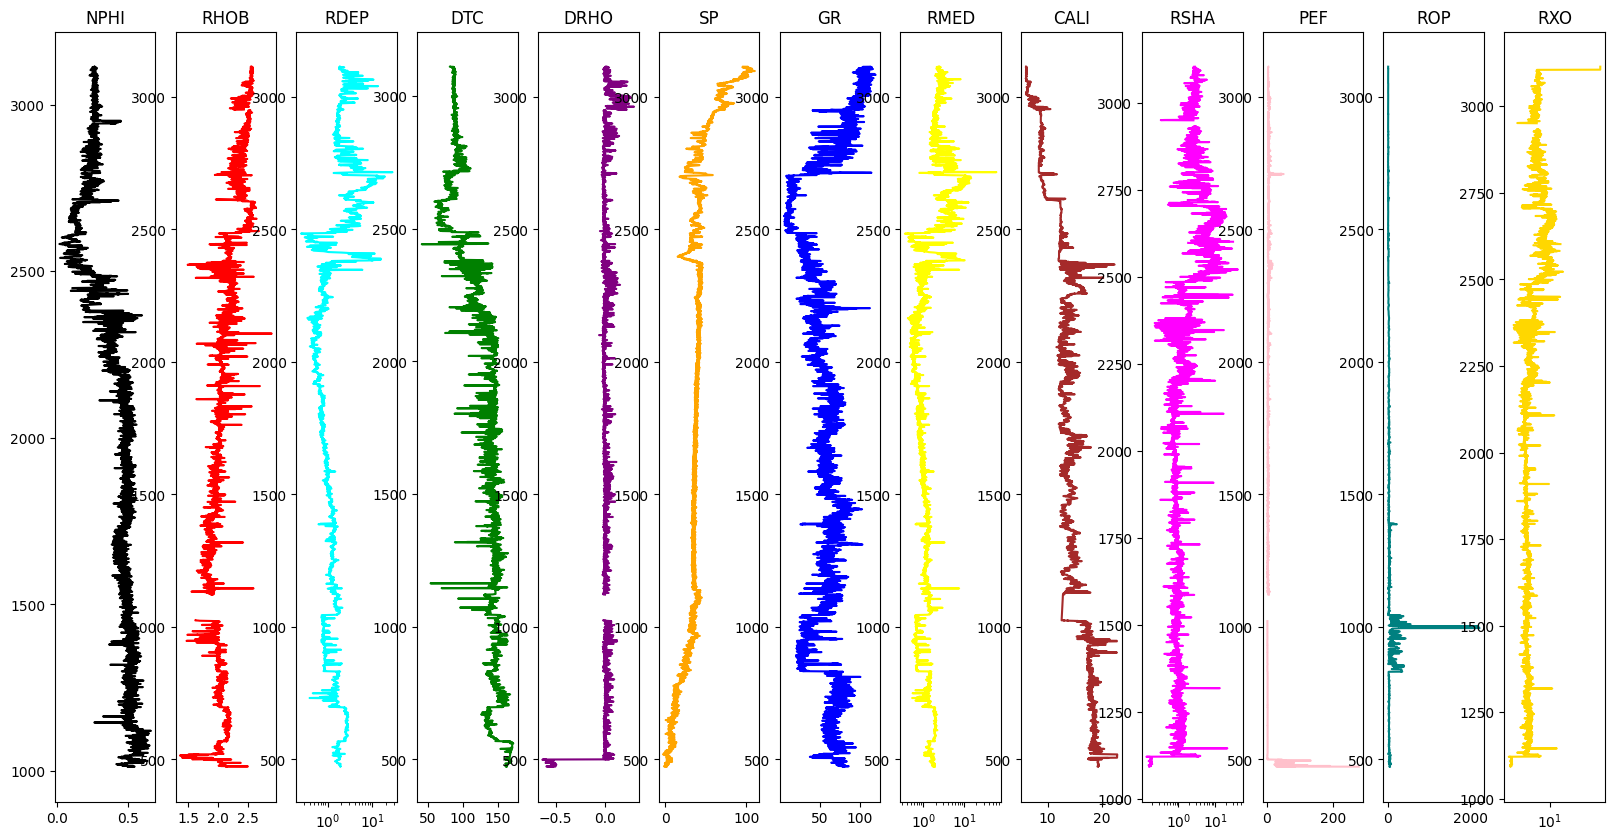

In [ ]:
logs = ['NPHI', 'RHOB', 'RDEP', 'DTC', 'DRHO', 'SP', 'GR', 'RMED', 'CALI', 'RSHA', 'PEF', 'ROP', 'RXO']

fig, ax = plt.subplots(nrows=1, ncols=len(logs), figsize=(20,10))

colors = ['black', 'red', 'cyan', 'green', 'purple', 'orange', 'blue', 'yellow', 'brown', 'magenta', 'pink', 'teal', 'gold' ]

for i in range(len(logs)):
  ## semilog plot for resistivity measurements
  if i == 2:
    ax[i].semilogx(df_train.loc[df_train['WELL'] == '15/9-17'][logs[i]], df_train.loc[df_train['WELL'] == '15/9-17']['DEPTH_MD'], color=colors[i])
  elif i == 7 :
     ax[i].semilogx(df_train.loc[df_train['WELL'] == '15/9-17'][logs[i]], df_train.loc[df_train['WELL'] == '15/9-17']['DEPTH_MD'], color=colors[i])
  elif i == 9 :
     ax[i].semilogx(df_train.loc[df_train['WELL'] == '15/9-17'][logs[i]], df_train.loc[df_train['WELL'] == '15/9-17']['DEPTH_MD'], color=colors[i])
  elif i == 12 :
     ax[i].semilogx(df_train.loc[df_train['WELL'] == '15/9-17'][logs[i]], df_train.loc[df_train['WELL'] == '15/9-17']['DEPTH_MD'], color=colors[i])
  ## normal plot for non-resistivity measurements
  else:
    ax[i].plot(df_train.loc[df_train['WELL'] == '15/9-17'][logs[i]], df_train.loc[df_train['WELL'] == '15/9-17']['DEPTH_MD'], color=colors[i])

  ax[i].set_title(logs[i])

plt.show()

## Feature Engineering

In [9]:
well_names = df_train.WELL.unique()
X_cord = df_train.groupby(['WELL'])['X_LOC'].mean()
Y_cord = df_train.groupby(['WELL'])['Y_LOC'].mean()
Z_cord = df_train.groupby(['WELL'])['Z_LOC'].mean()
wells_df = pd.DataFrame({'WELL':well_names, 'X_LOC': X_cord, 'Y_LOC': Y_cord})
wells_df.head(10)

,WELL,X_LOC,Y_LOC
WELL,,,
15/9-13,15/9-13,437627.322429,6.470979e+06
15/9-15,15/9-15,436809.066756,6.463002e+06
15/9-17,15/9-17,438595.049195,6.478958e+06
16/1-2,16/1-2,455221.343750,6.533322e+06
16/1-6 A,16/1-6 A,459499.134117,6.539492e+06
16/10-1,16/10-1,444158.759487,6.435559e+06
16/10-2,16/10-2,443273.027185,6.444988e+06
16/10-3,16/10-3,460430.217397,6.453748e+06
16/10-5,16/10-5,448702.205433,6.429293e+06


In [10]:
df_train['X_LOC'] = df_train['WELL'].map(X_cord)
df_train['Y_LOC'] = df_train['WELL'].map(Y_cord)
df_train['Z_LOC'] = df_train['WELL'].map(Z_cord)
df_train.head(10)

,WELL,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,GROUP,FORMATION,CALI,RSHA,RMED,...,ROP,DTS,DCAL,DRHO,MUDWEIGHT,RMIC,ROPA,RXO,Lithology,Confidence
0,15/9-13,494.528,437627.322429,6.470979e+06,-1857.98524,NORDLAND GP.,NaN,19.480835,NaN,1.611410,...,34.636410,NaN,NaN,-0.574928,NaN,NaN,NaN,NaN,Shale,1.0
1,15/9-13,494.680,437627.322429,6.470979e+06,-1857.98524,NORDLAND GP.,NaN,19.468800,NaN,1.618070,...,34.636410,NaN,NaN,-0.570188,NaN,NaN,NaN,NaN,Shale,1.0
2,15/9-13,494.832,437627.322429,6.470979e+06,-1857.98524,NORDLAND GP.,NaN,19.468800,NaN,1.626459,...,34.779556,NaN,NaN,-0.574245,NaN,NaN,NaN,NaN,Shale,1.0
3,15/9-13,494.984,437627.322429,6.470979e+06,-1857.98524,NORDLAND GP.,NaN,19.459282,NaN,1.621594,...,39.965164,NaN,NaN,-0.586315,NaN,NaN,NaN,NaN,Shale,1.0
4,15/9-13,495.136,437627.322429,6.470979e+06,-1857.98524,NORDLAND GP.,NaN,19.453100,NaN,1.602679,...,57.483765,NaN,NaN,-0.597914,NaN,NaN,NaN,NaN,Shale,1.0
5,15/9-13,495.288,437627.322429,6.470979e+06,-1857.98524,NORDLAND GP.,NaN,19.453100,NaN,1.585567,...,75.281410,NaN,NaN,-0.601600,NaN,NaN,NaN,NaN,Shale,1.0
6,15/9-13,495.440,437627.322429,6.470979e+06,-1857.98524,NORDLAND GP.,NaN,19.462496,NaN,1.576569,...,76.199951,NaN,NaN,-0.598369,NaN,NaN,NaN,NaN,Shale,1.0
7,15/9-13,495.592,437627.322429,6.470979e+06,-1857.98524,NORDLAND GP.,NaN,19.468800,NaN,1.587011,...,76.199951,NaN,NaN,-0.602039,NaN,NaN,NaN,NaN,Shale,1.0
8,15/9-13,495.744,437627.322429,6.470979e+06,-1857.98524,NORDLAND GP.,NaN,19.468800,NaN,1.613674,...,75.898796,NaN,NaN,-0.614364,NaN,NaN,NaN,NaN,Shale,1.0
9,15/9-13,495.896,437627.322429,6.470979e+06,-1857.98524,NORDLAND GP.,NaN,19.468800,NaN,1.634622,...,68.121262,NaN,NaN,-0.621813,NaN,NaN,NaN,NaN,Shale,1.0


In [11]:
dftype = pd.DataFrame(df_train.dtypes, columns=['Data_Type'])
dftype['Number_Unique'] = df_train.nunique()
dftype['Number_of_Nan'] = df_train.isna().sum()
dftype

,Data_Type,Number_Unique,Number_of_Nan
WELL,object,98,0
DEPTH_MD,float64,1146418,0
X_LOC,float64,98,0
Y_LOC,float64,98,0
Z_LOC,float64,98,0
GROUP,object,14,1278
FORMATION,object,69,136994
CALI,float64,874208,87877
RSHA,float64,619225,539861
RMED,float64,1104594,38993


### Outlier Detection

In [109]:
logs = [col for col in df_train.columns[7:27]]
skew={}
for log in logs:
    print(f"{log} : {df_train[log].skew()}")
    skew[log]={df_train[log].skew()}

CALI : 0.4570944494943054
RSHA : 16.086033712617464
RMED : 33.01077433645617
RDEP : 15.775403482533275
RHOB : -0.5507124236432258
GR : 1.67299746256842
SGR : 0.6585757362098044
NPHI : 0.3373864770662079
PEF : 13.979143847117987
DTC : 0.1524848175127283
SP : -0.840737155749676
BS : 0.7475367423184963
ROP : 17.021738203362094
DTS : 1.6839695050217576
DCAL : 181.3515610230231
DRHO : -992.747144871404
MUDWEIGHT : 15.685729187157094
RMIC : 58.19851473111231
ROPA : -11.833559010644752
RXO : 10.2045508153743


      Feature  Outlier Count
2        RMED         141472
3        RDEP         134735
15       DRHO          99896
10         SP          95482
1        RSHA          78325
19        RXO          73602
8         PEF          57091
12        ROP          33986
5          GR          27792
17       RMIC          18197
14       DCAL          16944
13        DTS          12689
4        RHOB           8368
18       ROPA           7427
7        NPHI           5859
11         BS           2744
16  MUDWEIGHT           1134
6         SGR            697
0        CALI            300
9         DTC             55


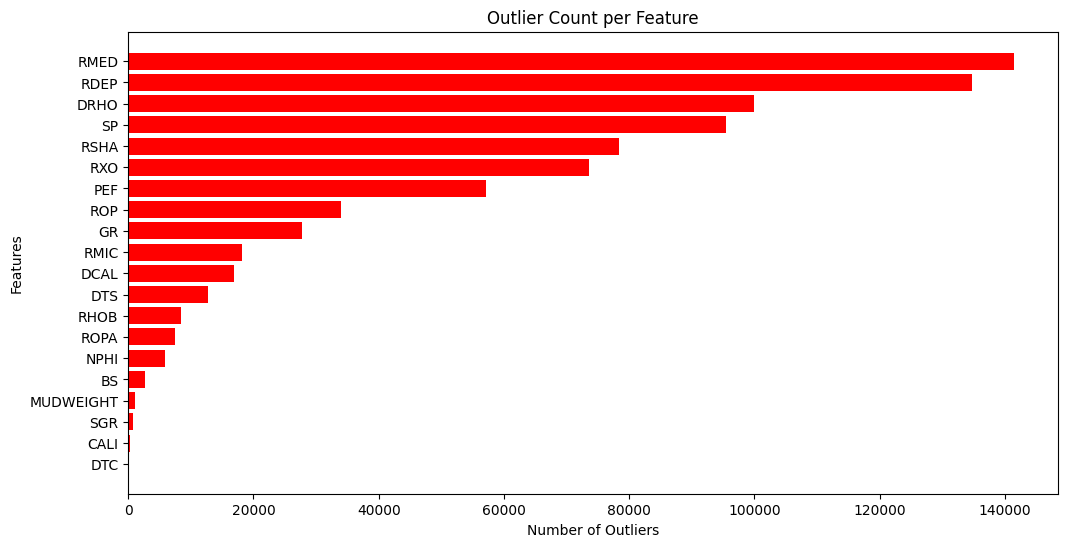

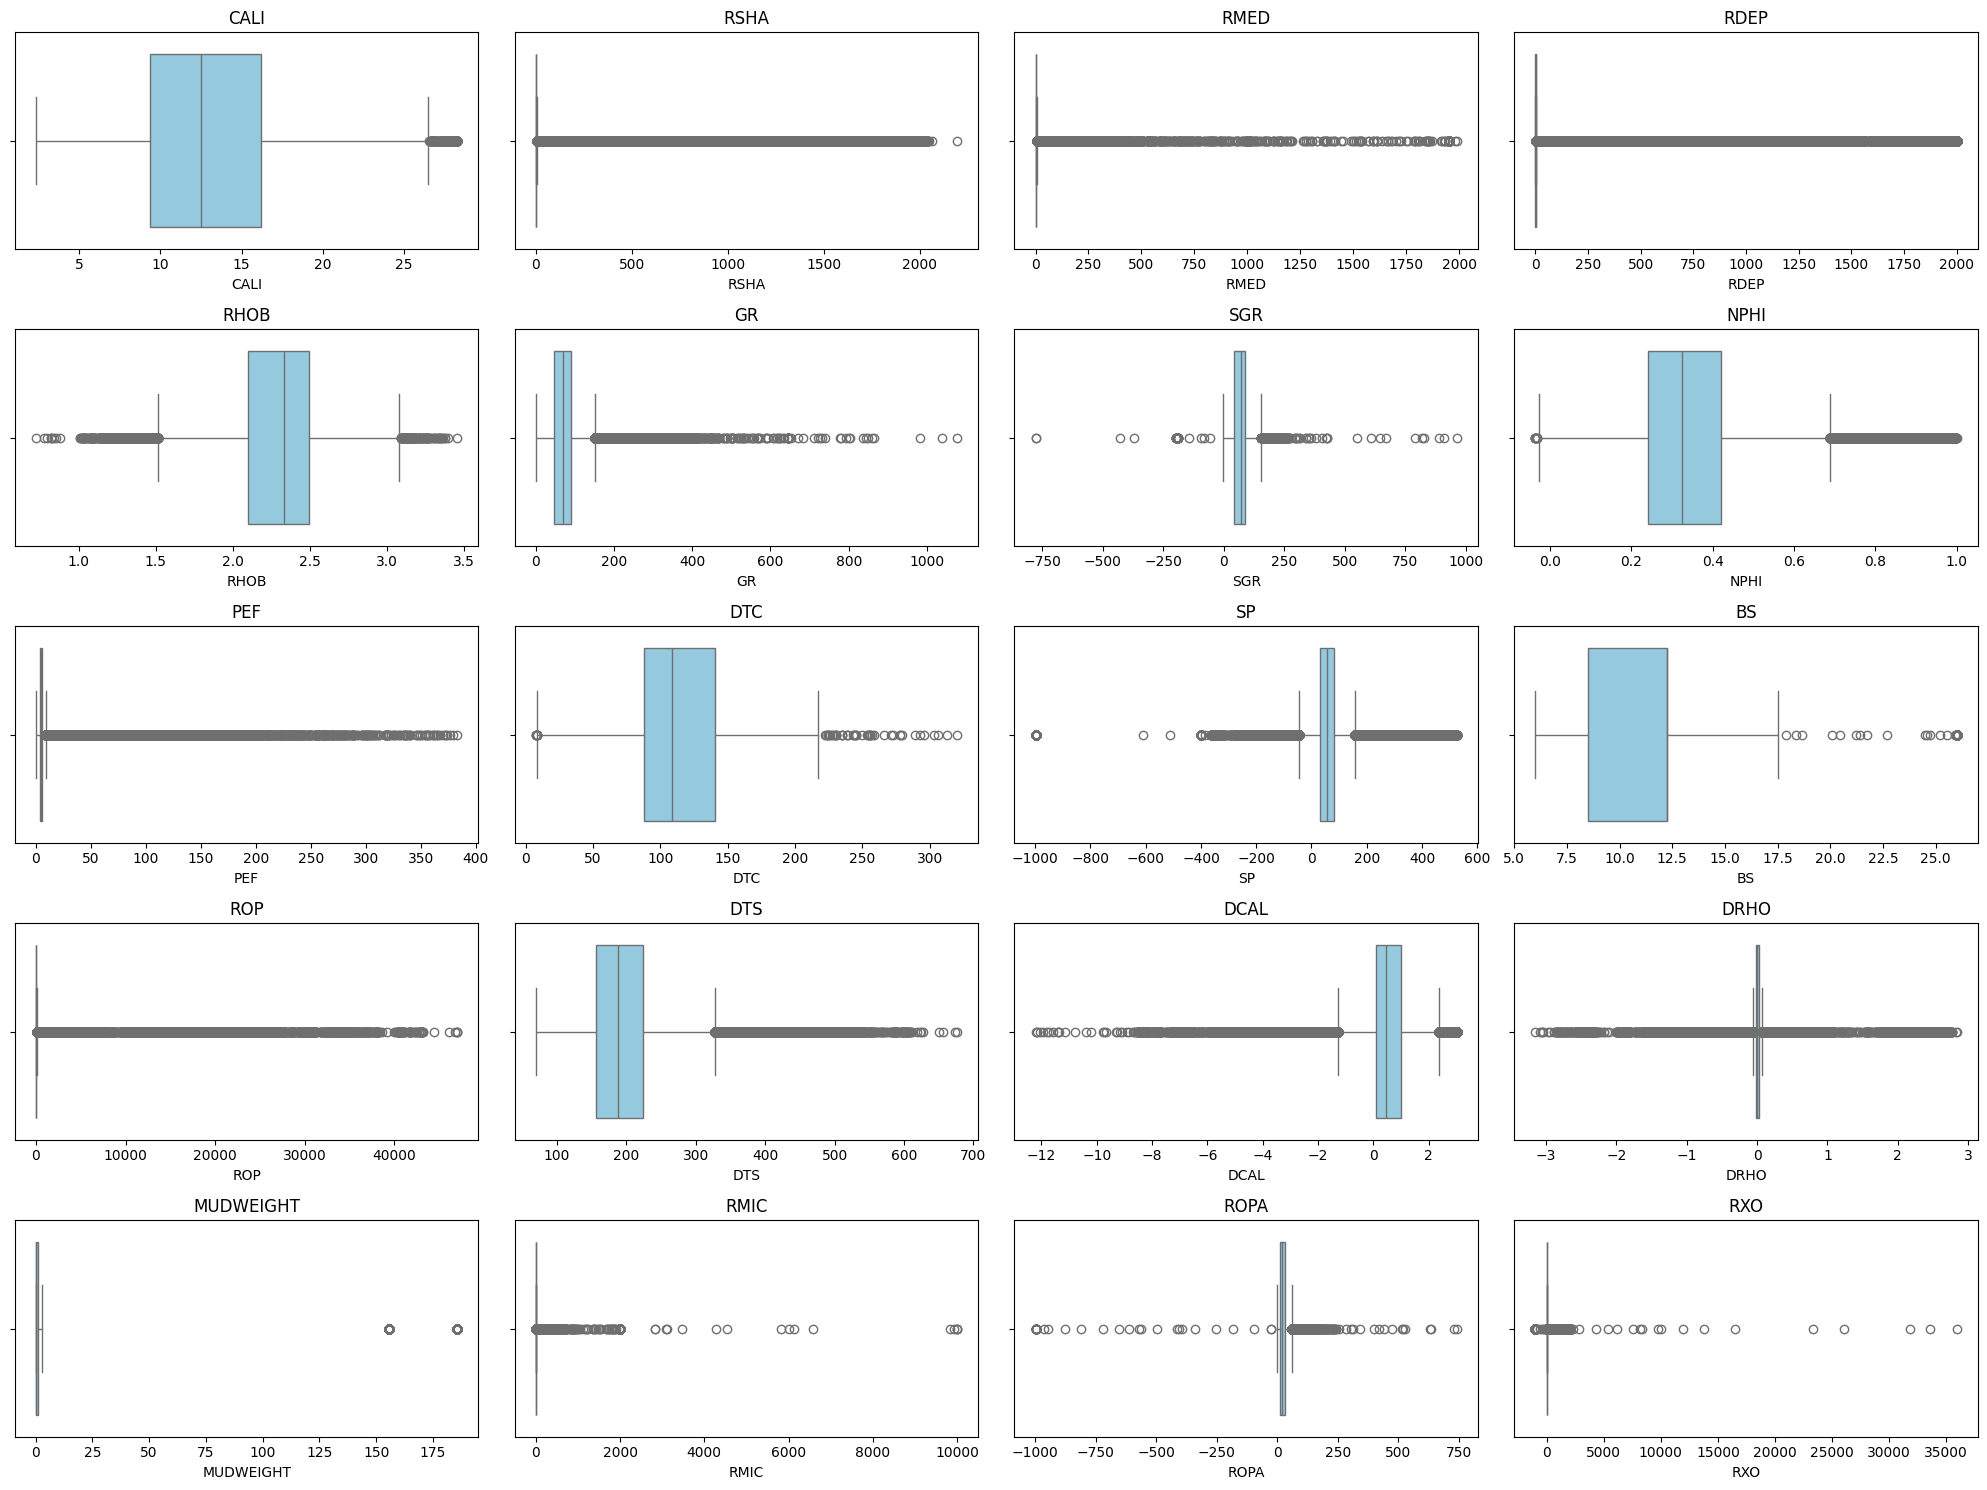

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Selecting the relevant feature columns
logs = [col for col in df_train.columns[7:27]]

# Dictionary to store outlier counts
outlier_counts = {}

# Detecting outliers using the IQR method
for log in logs:
    Q1 = df_train[log].quantile(0.25)
    Q3 = df_train[log].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Identifying outliers
    outliers = df_train[(df_train[log] < lower_bound) | (df_train[log] > upper_bound)]
    outlier_counts[log] = outliers.shape[0]

# Convert dictionary to DataFrame for better visualization
outlier_df = pd.DataFrame(list(outlier_counts.items()), columns=['Feature', 'Outlier Count'])

# Sorting in descending order of outlier count
outlier_df = outlier_df.sort_values(by='Outlier Count', ascending=False)

# Displaying outlier counts
print(outlier_df)

# Plotting the outlier counts
plt.figure(figsize=(12, 6))
plt.barh(outlier_df['Feature'], outlier_df['Outlier Count'], color='red')
plt.xlabel('Number of Outliers')
plt.ylabel('Features')
plt.title('Outlier Count per Feature')
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()

# --- Feature-wise Box Plots ---
plt.figure(figsize=(20, 15))
for i, log in enumerate(logs):
    plt.subplot(5, 4, i+1)
    sns.boxplot(x=df_train[log], color='skyblue')
    plt.title(log)
plt.tight_layout()
plt.show()

In [110]:
df_train = df_train[df_train['DRHO'] != df_train['DRHO'].min()]

In [111]:
Q1 = df_train['DCAL'].quantile(0.25)
Q3 = df_train['DCAL'].quantile(0.75)
IQR = Q3 - Q1
upper_bound = Q3 + 1.5 * IQR

# Keep only rows where all values are below their respective upper bounds
df_train = df_train[~(df_train['DCAL'] > upper_bound)]

In [112]:
logs = [col for col in df_train.columns[7:27]]
skew={}
for log in logs:
    print(f"{log} : {df_train[log].skew()}")
    skew[log]={df_train[log].skew()}

CALI : 0.46711551677873125
RSHA : 16.168585987657455
RMED : 32.72710049828068
RDEP : 15.612930677247238
RHOB : -0.5773211007920096
GR : 1.6723463130813907
SGR : 0.6569281535147279
NPHI : 0.36374122245893165
PEF : 14.115150733084446
DTC : 0.17648896519272117
SP : -0.9407257359830189
BS : 0.7746927719164595
ROP : 16.730311305729124
DTS : 1.6907822767019336
DCAL : -3.164691927406718
DRHO : 8.253228541520704
MUDWEIGHT : 16.271007482120556
RMIC : 57.29418116844439
ROPA : -11.833840431276476
RXO : 10.46948714626558


['CALI', 'RSHA', 'RMED', 'RDEP', 'RHOB', 'GR', 'SGR', 'NPHI', 'PEF', 'DTC', 'SP', 'BS', 'ROP', 'DTS', 'DCAL', 'DRHO', 'MUDWEIGHT', 'RMIC', 'ROPA', 'RXO']


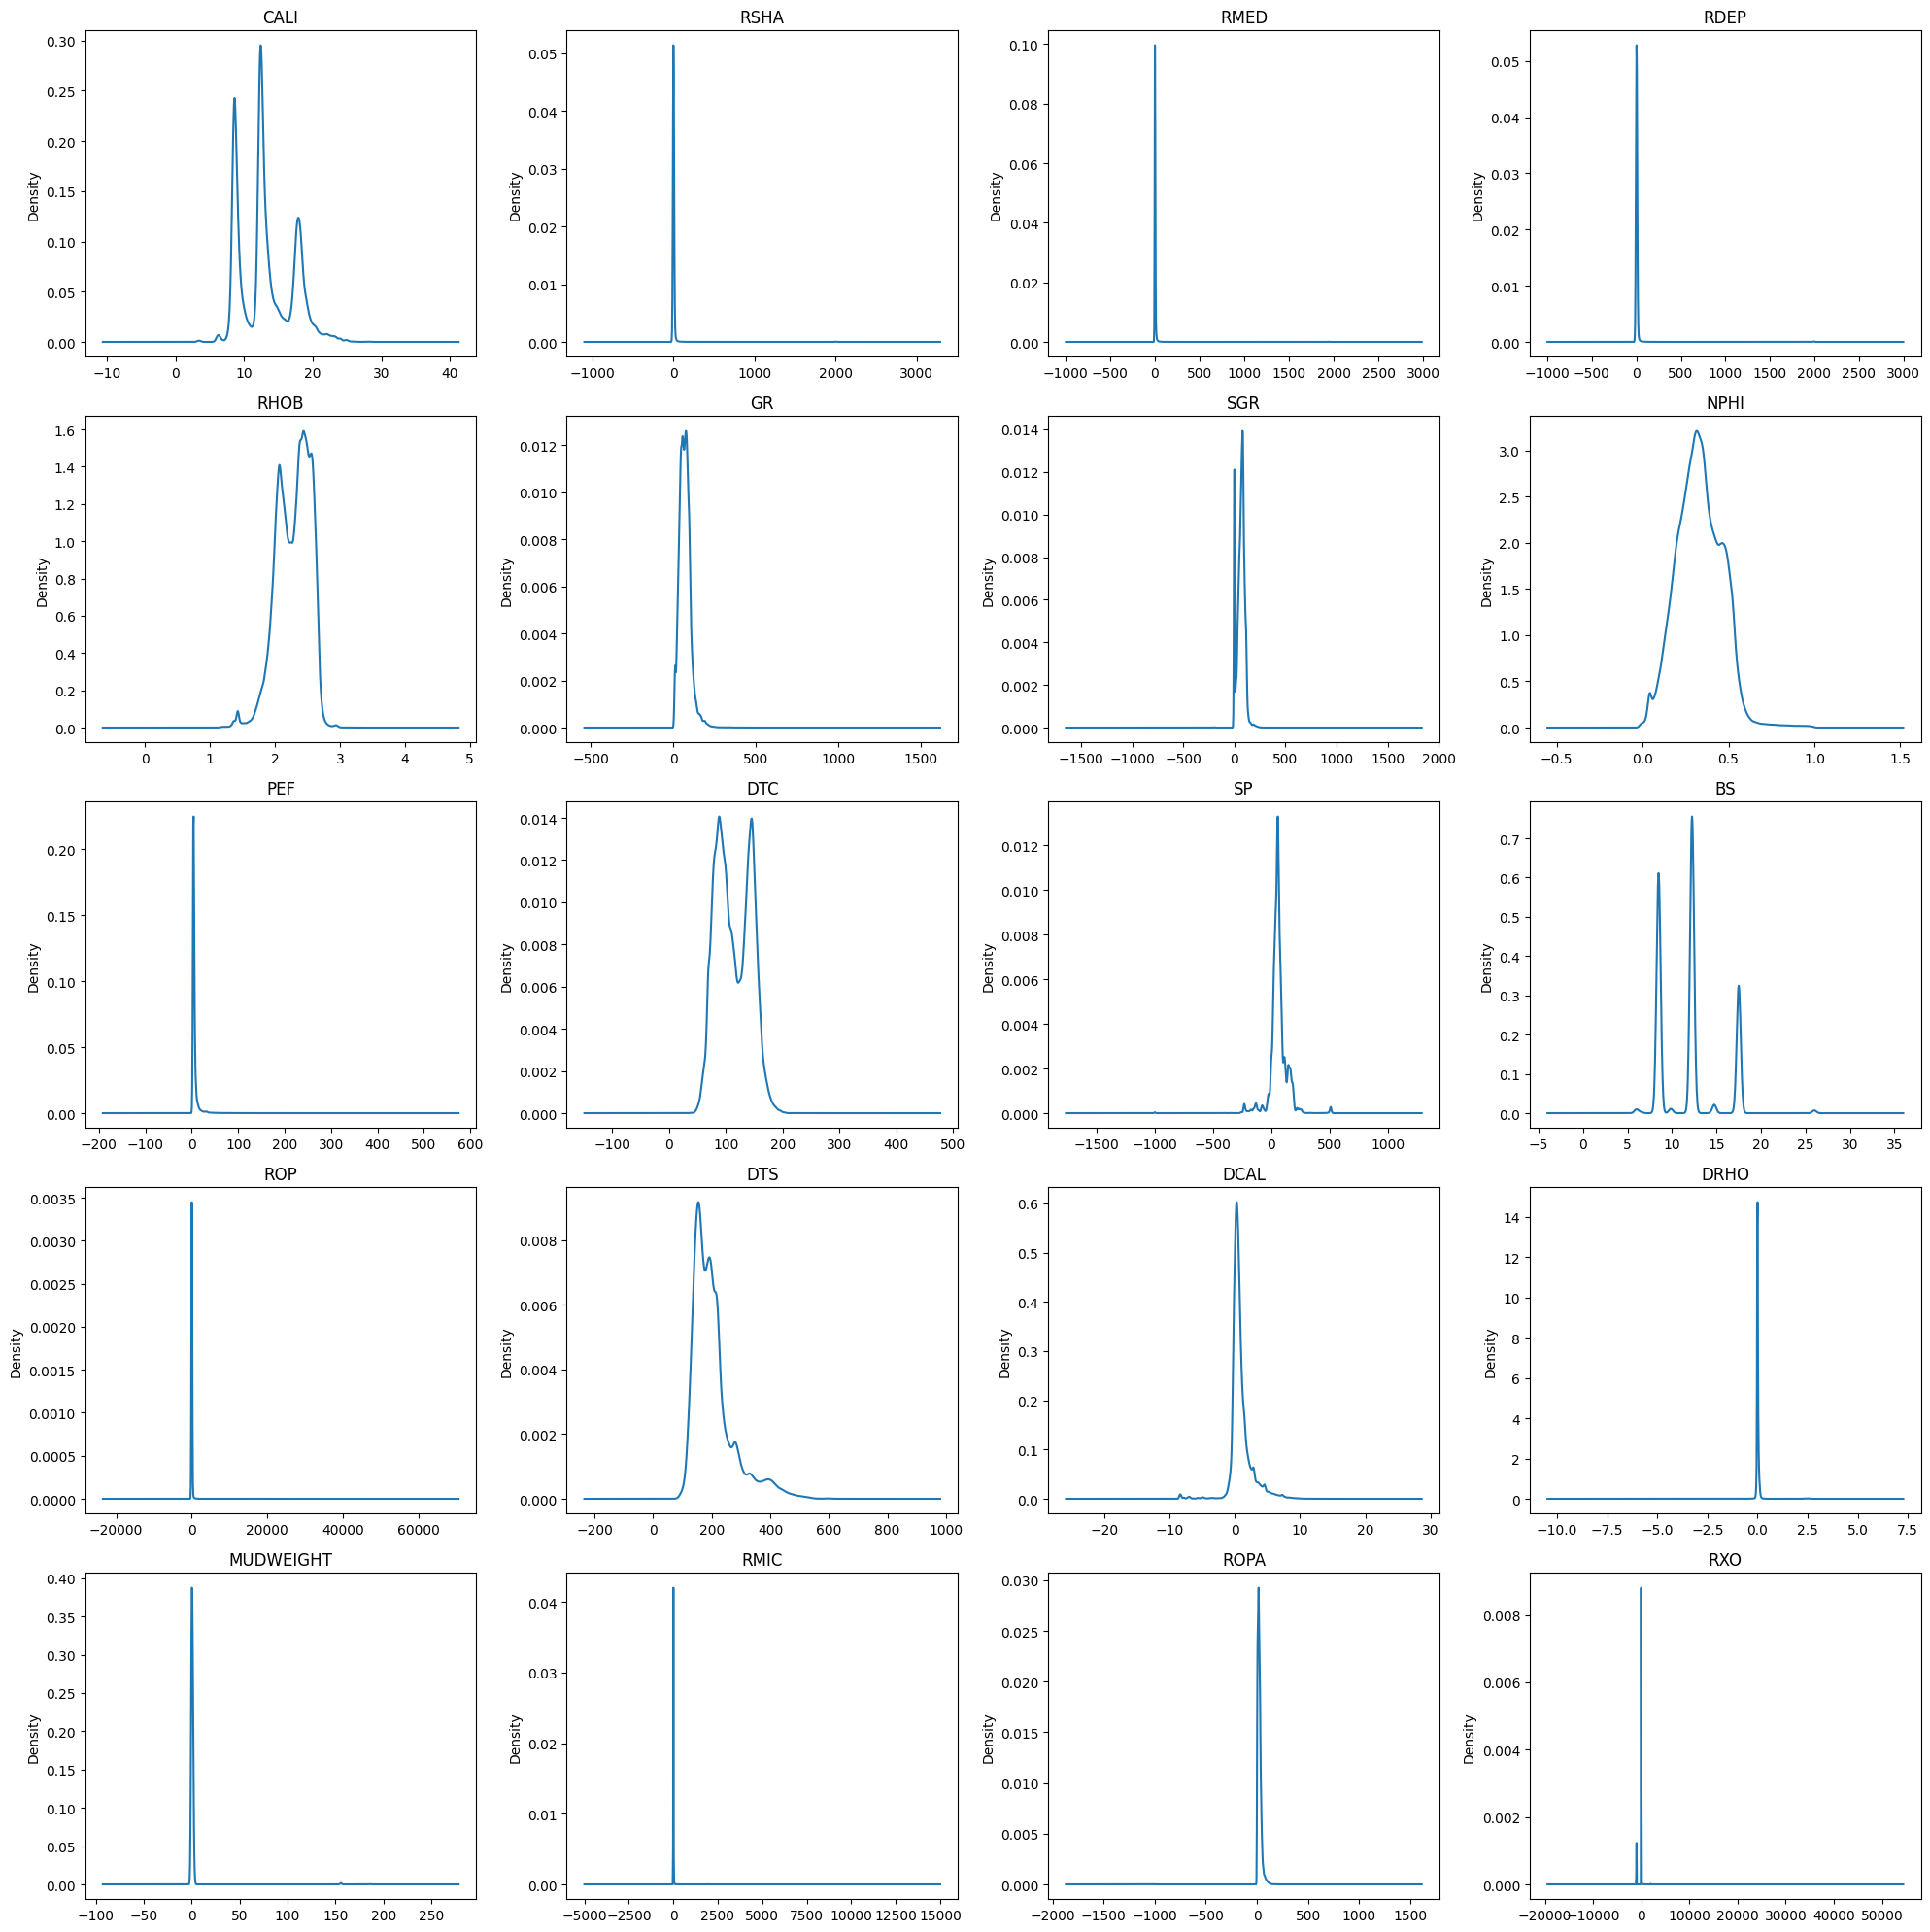

In [ ]:
logs = [col for col in df_train.columns[7:27]]
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(20, 20))
axes = axes.flatten()
print(logs)
for i in range(len(logs)):
  df_train[logs[i]].plot(kind='kde', ax=axes[i])
  axes[i].set_title(logs[i])
plt.tight_layout()
plt.show()

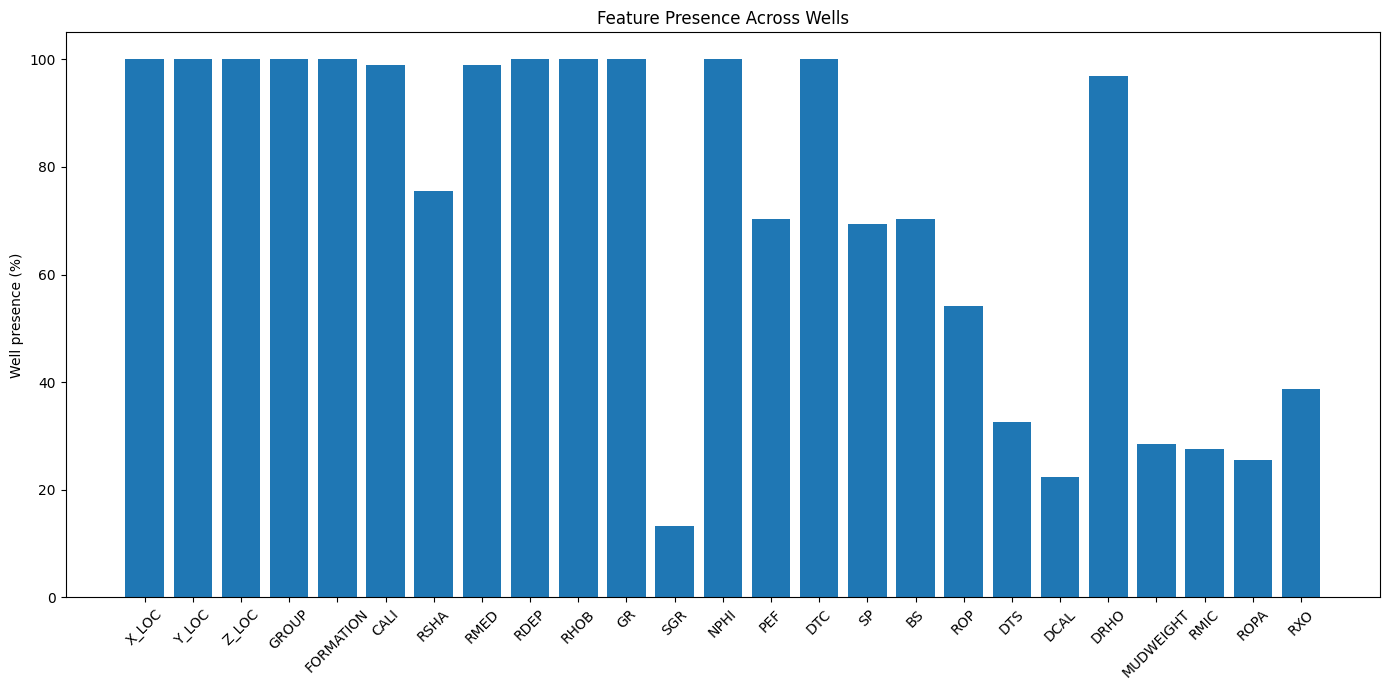

In [ ]:
occurrences = np.zeros(25)
for well in df_train['WELL'].unique():
    occurrences += df_train[df_train['WELL'] == well].isna().all().astype(int).values[2:-2]

fig, ax = plt.subplots(1, 1, figsize=(14, 7))
ax.bar(x=np.arange(occurrences.shape[0]),
       height=(df_train['WELL'].nunique() - occurrences) / df_train['WELL'].nunique() * 100.0)
ax.set_xticks(np.arange(occurrences.shape[0]))
ax.set_xticklabels(df_train.columns[2:-2], rotation=45)
ax.set_ylabel('Well presence (%)')
ax.set_title('Feature Presence Across Wells')
plt.tight_layout()
plt.show()

### Data Preparation for Training

In [113]:
x_train = df_train.drop(columns=['WELL', 'Lithology', 'Confidence'])
x_hiddentest = df_hiddentest.drop(columns=['WELL', 'Lithology', 'Confidence'])

In [114]:
x_train.columns
x_hiddentest.columns

Index(['DEPTH_MD', 'X_LOC', 'Y_LOC', 'Z_LOC', 'GROUP', 'FORMATION', 'CALI',
       'RSHA', 'RMED', 'RDEP', 'RHOB', 'GR', 'SGR', 'NPHI', 'PEF', 'DTC', 'SP',
       'BS', 'ROP', 'DTS', 'DCAL', 'DRHO', 'MUDWEIGHT', 'RMIC', 'ROPA', 'RXO'],
      dtype='object')

In [115]:
cols_to_drop = ['RSHA', 'GROUP', 'FORMATION','X_LOC', 'Y_LOC', 'Z_LOC','MUDWEIGHT', 'DCAL', 'RXO', 'RMIC', 'DTS', 'BS', 'ROPA', 'SGR']

x_train = x_train.drop(columns=x_train.columns.intersection(cols_to_drop), axis=1)
x_hiddentest = x_hiddentest.drop(columns=x_hiddentest.columns.intersection(cols_to_drop), axis=1)

In [116]:
x_train.columns
x_hiddentest.columns

Index(['DEPTH_MD', 'CALI', 'RMED', 'RDEP', 'RHOB', 'GR', 'NPHI', 'PEF', 'DTC',
       'SP', 'ROP', 'DRHO'],
      dtype='object')

In [117]:
y_train=df_train['Lithology']
y_train.value_counts()

,count
Lithology,
Shale,701750
Sandstone,166341
Sandstone/Shale,148897
Limestone,55822
Marl,32698
Tuff,15080
Chalk,9887
Halite,8207
Coal,3495


In [118]:
y_hiddentest = df_hiddentest['Lithology']
y_hiddentest.value_counts()

,count
Lithology,
Shale,71827
Sandstone,14045
Sandstone/Shale,12283
Limestone,8374
Halite,6498
Marl,4396
Chalk,2905
Tuff,941
Anhydrite,597


In [119]:
lithology_numbers = {'Sandstone': 0,
                 'Sandstone/Shale': 1,
                 'Shale': 2,
                 'Marl': 3,
                 'Dolomite': 4,
                 'Limestone': 5,
                 'Chalk': 6,
                 'Halite': 7,
                 'Anhydrite': 8,
                 'Tuff': 9,
                 'Coal': 10,
                 'Basement': 11}
y_train = y_train.map(lithology_numbers)
y_hiddentest = y_hiddentest.map(lithology_numbers)

### Imputations:

In [120]:
dftype = pd.DataFrame(x_train.dtypes, columns=['Data_Type'])
dftype['Number_Unique'] = x_train.nunique()
dftype['Number_of_Nan'] = x_train.isna().sum()
dftype['Percentage_of_Nan'] = x_train.isna().sum()/ df_train.shape[0] * 100
dftype['Skewness'] = x_train.skew()
dftype

,Data_Type,Number_Unique,Number_of_Nan,Percentage_of_Nan,Skewness
DEPTH_MD,float64,1124112,0,0.000000,0.399079
CALI,float64,850872,87867,7.674128,0.467116
RMED,float64,1080150,38842,3.392383,32.727100
RDEP,float64,1106911,11011,0.961679,15.612931
RHOB,float64,854530,160524,14.019845,-0.577321
GR,float64,1109660,0,0.000000,1.672346
NPHI,float64,724005,393050,34.328200,0.363741
PEF,float64,641098,490060,42.800860,14.115151
DTC,float64,1006883,79682,6.959266,0.176489
SP,float64,808359,305299,26.664204,-0.940726


In [121]:
dftype = pd.DataFrame(x_hiddentest.dtypes, columns=['Data_Type'])
dftype['Number_Unique'] = x_hiddentest.nunique()
dftype['Number_of_Nan'] = x_hiddentest.isna().sum()
dftype['Percentage_of_Nan'] = x_hiddentest.isna().sum()/ df_train.shape[0] * 100
dftype['Skewness'] = x_hiddentest.skew()
dftype

,Data_Type,Number_Unique,Number_of_Nan,Percentage_of_Nan,Skewness
DEPTH_MD,float64,122397,0,0.000000,0.149180
CALI,float64,108420,3443,0.300705,0.662007
RMED,float64,112153,9817,0.857397,42.878298
RDEP,float64,121984,11,0.000961,5.596556
RHOB,float64,110600,9528,0.832156,-0.766970
GR,float64,121999,0,0.000000,1.449487
NPHI,float64,96054,25837,2.256552,-0.056124
PEF,float64,100061,21958,1.917768,18.763544
DTC,float64,117438,4106,0.358610,0.163526
SP,float64,44091,75672,6.609041,-0.602195


In [122]:
from sklearn.impute import KNNImputer
import numpy as np

skew_values = x_train.skew()

mean_impute_cols = []
median_impute_cols = []
knn_impute_cols = []

for col, skew in skew_values.items():
    if -1 <= skew <= 1:
        mean_impute_cols.append(col)
    elif -3 <= skew < -1 or 1 < skew <= 3:
        median_impute_cols.append(col)
    else:
        knn_impute_cols.append(col)

print("Mean Imputation Columns:", mean_impute_cols)
print("Median Imputation Columns:", median_impute_cols)
print("KNN Imputation Columns:", knn_impute_cols)


Mean Imputation Columns: ['DEPTH_MD', 'CALI', 'RHOB', 'NPHI', 'DTC', 'SP']
Median Imputation Columns: ['GR']
KNN Imputation Columns: ['RMED', 'RDEP', 'PEF', 'ROP', 'DRHO']


In [123]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [124]:
import cuml
print(cuml.__version__)

25.02.01


In [125]:
import pandas as pd
import cudf
import cupy as cp
from cuml.neighbors import KNeighborsRegressor
from sklearn.impute import SimpleImputer

def mean_median_impute_cpu(df, mean_cols, median_cols):
    """
    Performs mean and median imputation using CPU-based SimpleImputer.
    """
    df_imputed = df.copy()

    # 🟢 Mean Imputation (CPU)
    if mean_cols:
        mean_imputer = SimpleImputer(strategy="mean")
        df_imputed[mean_cols] = mean_imputer.fit_transform(df[mean_cols])

    # 🟠 Median Imputation (CPU)
    if median_cols:
        median_imputer = SimpleImputer(strategy="median")
        df_imputed[median_cols] = median_imputer.fit_transform(df[median_cols])

    return df_imputed


def knn_impute_gpu(df, knn_cols, n_neighbors=3):
    """
    Performs KNN imputation on specified columns using cuML (GPU-accelerated).
    """
    df_filled = df.copy()
    gdf = cudf.DataFrame.from_pandas(df)  # Convert pandas DataFrame to cuDF

    for col in knn_cols:
        missing_mask = gdf[col].isna()
        if missing_mask.sum() == 0:
            continue  # Skip if no missing values

        # Instead of dropping rows, use only the columns needed for KNN
        known_data = gdf[~missing_mask][[col] + [c for c in gdf.columns if c != col and c not in knn_cols]].dropna()
        unknown_data = gdf[missing_mask][[c for c in gdf.columns if c != col and c not in knn_cols]].dropna()

        # Ensure that known_data and unknown_data have matching number of features:
        num_features_known = known_data.shape[1] - 1  # Exclude the target column
        num_features_unknown = unknown_data.shape[1]

        # If num_features don't match, skip imputation for this column:
        if num_features_known != num_features_unknown:
            print(f"Skipping imputation for column '{col}' due to feature mismatch.")
            continue

        # Train KNN on available data using pandas DataFrames:
        knn = KNeighborsRegressor(n_neighbors=n_neighbors, metric="euclidean")
        knn.fit(known_data[[c for c in known_data.columns if c != col]].to_pandas().values,
                known_data[col].to_pandas().values)

        # Predict missing values:
        imputed_values = knn.predict(unknown_data.to_pandas().values)

        # Get the indices of missing values in the original pandas DataFrame:
        missing_indices = df[df[col].isnull()].index

        # Assign back to DataFrame using missing_indices and imputed_values:
        df_filled.loc[missing_indices, col] = imputed_values

    return df_filled  # Convert back to pandas


# 🏗 **Apply Imputations Using Precomputed Column Lists**
x_train = mean_median_impute_cpu(x_train, mean_impute_cols, median_impute_cols)
x_train = knn_impute_gpu(x_train, knn_impute_cols)

# ✅ **Check for Remaining NaN Values**
missing_after_imputation = x_train.isnull().sum().sum()
print(f"Total missing values after imputation: {missing_after_imputation}")

Total missing values after imputation: 0


In [126]:
import pandas as pd
import cudf
import cupy as cp
from cuml.neighbors import KNeighborsRegressor
from sklearn.impute import SimpleImputer

def mean_median_impute_cpu(df, mean_cols, median_cols):
    """
    Performs mean and median imputation using CPU-based SimpleImputer.
    """
    df_imputed = df.copy()

    # 🟢 Mean Imputation (CPU)
    if mean_cols:
        mean_imputer = SimpleImputer(strategy="mean")
        df_imputed[mean_cols] = mean_imputer.fit_transform(df[mean_cols])

    # 🟠 Median Imputation (CPU)
    if median_cols:
        median_imputer = SimpleImputer(strategy="median")
        df_imputed[median_cols] = median_imputer.fit_transform(df[median_cols])

    return df_imputed


def knn_impute_gpu(df, knn_cols, n_neighbors=3):
    """
    Performs KNN imputation on specified columns using cuML (GPU-accelerated).
    """
    df_filled = df.copy()
    gdf = cudf.DataFrame.from_pandas(df)  # Convert pandas DataFrame to cuDF

    for col in knn_cols:
        missing_mask = gdf[col].isna()
        if missing_mask.sum() == 0:
            continue  # Skip if no missing values

        # Instead of dropping rows, use only the columns needed for KNN
        known_data = gdf[~missing_mask][[col] + [c for c in gdf.columns if c != col and c not in knn_cols]].dropna()
        unknown_data = gdf[missing_mask][[c for c in gdf.columns if c != col and c not in knn_cols]].dropna()

        # Ensure that known_data and unknown_data have matching number of features:
        num_features_known = known_data.shape[1] - 1  # Exclude the target column
        num_features_unknown = unknown_data.shape[1]

        # If num_features don't match, skip imputation for this column:
        if num_features_known != num_features_unknown:
            print(f"Skipping imputation for column '{col}' due to feature mismatch.")
            continue

        # Train KNN on available data using pandas DataFrames:
        knn = KNeighborsRegressor(n_neighbors=n_neighbors, metric="euclidean")
        knn.fit(known_data[[c for c in known_data.columns if c != col]].to_pandas().values,
                known_data[col].to_pandas().values)

        # Predict missing values:
        imputed_values = knn.predict(unknown_data.to_pandas().values)

        # Get the indices of missing values in the original pandas DataFrame:
        missing_indices = df[df[col].isnull()].index

        # Assign back to DataFrame using missing_indices and imputed_values:
        df_filled.loc[missing_indices, col] = imputed_values

    return df_filled  # Convert back to pandas


# 🏗 **Apply Imputations Using Precomputed Column Lists**
x_hiddentest = mean_median_impute_cpu(x_hiddentest, mean_impute_cols, median_impute_cols)
x_hiddentest = knn_impute_gpu(x_hiddentest, knn_impute_cols)

# ✅ **Check for Remaining NaN Values**
missing_after_imputation = x_hiddentest.isnull().sum().sum()
print(f"Total missing values after imputation: {missing_after_imputation}")

Total missing values after imputation: 0


### Feature Construction:

In [28]:
# x_train['RHOB'] = x_train['RHOB'] - x_train['DRHO']
# x_hiddentest['RHOB'] = x_hiddentest['RHOB'] - x_hiddentest['DRHO']

In [29]:
# x_train = x_train.drop(columns=['DRHO'])
# x_hiddentest = x_hiddentest.drop(columns=['DRHO'])

### Scaling:

In [31]:
# knn_impute_cols = [col for col in knn_impute_cols if col != 'DRHO']

In [127]:
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer

# 🟩 Apply StandardScaler to columns with skew in [-1, 1]
scaler = StandardScaler()
x_train[mean_impute_cols] = scaler.fit_transform(x_train[mean_impute_cols])
x_hiddentest[mean_impute_cols] = scaler.transform(x_hiddentest[mean_impute_cols])

# 🟩 Apply RobustScaler to columns with high skewness
robust_scaler = RobustScaler()
x_train[median_impute_cols] = robust_scaler.fit_transform(x_train[median_impute_cols])
x_hiddentest[median_impute_cols] = robust_scaler.transform(x_hiddentest[median_impute_cols])

# 🟩 Apply PowerTransformer (Yeo-Johnson) to highly skewed columns
power_transformer = PowerTransformer(method='yeo-johnson')
x_train[knn_impute_cols] = power_transformer.fit_transform(x_train[knn_impute_cols])
x_hiddentest[knn_impute_cols] = power_transformer.transform(x_hiddentest[knn_impute_cols])

### Spitting:

In [128]:
# 🟩 Split original x_train into training and cross-validation sets
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

## Model Fitting:

### Decision Tree Classification:

In [129]:
# Import necessary library
from sklearn.tree import DecisionTreeClassifier
model_dtree = DecisionTreeClassifier(random_state=42)
model_dtree.fit(x_train, y_train)

y_predtrain = model_dtree.predict(x_train)
y_predval = model_dtree.predict(x_val)
y_predhiddentest = model_dtree.predict(x_hiddentest)

In [130]:
from sklearn.metrics import accuracy_score

In [131]:
accuracy_score(y_predtrain, y_train)

1.0

In [132]:
accuracy_score(y_predval, y_val)

0.9101294345752764

In [133]:
accuracy_score(y_predhiddentest, y_hiddentest)

0.5945243755974411

In [134]:
# Import necessary library
from sklearn.tree import DecisionTreeClassifier
model_dtree2 = DecisionTreeClassifier(max_depth=13, random_state=42)
model_dtree2.fit(x_train, y_train)

y_predtrain = model_dtree2.predict(x_train)
y_predval = model_dtree2.predict(x_val)
y_predhiddentest = model_dtree2.predict(x_hiddentest)

In [135]:
accuracy_score(y_predtrain, y_train)

0.8515471390782123

In [136]:
accuracy_score(y_predval, y_val)

0.8421675487781446

In [137]:
accuracy_score(y_predhiddentest, y_hiddentest)

0.6860870772976462

## Random Forest Classifier

In [139]:
from cuml.ensemble import RandomForestClassifier

X_cudf = cudf.DataFrame(x_train)
Y_cudf = cudf.Series(y_train)
x_cudf_val = cudf.DataFrame(x_val)
x_cudf_hiddentest = cudf.DataFrame(x_hiddentest)

model_rforest = RandomForestClassifier(random_state=42, n_estimators=700, max_features=9, max_depth=13)
model_rforest.fit(X_cudf, Y_cudf)

y_predtrain = model_rforest.predict(X_cudf)
y_predval = model_rforest.predict(x_cudf_val)
y_predhiddentest = model_rforest.predict(x_cudf_hiddentest)

In [140]:
y_predtrain = y_predtrain.to_pandas()
y_predval = y_predval.to_pandas()
y_predhiddentest = y_predhiddentest.to_pandas()

In [141]:
accuracy_score(y_predtrain, y_train)

0.8657832422288235

In [142]:
accuracy_score(y_predval, y_val)

0.8561808939894147

In [143]:
accuracy_score(y_predhiddentest, y_hiddentest)

0.7262106097371668

## XGBoost Classifier

In [144]:
import xgboost
from xgboost import XGBClassifier

xgboost.set_config(verbosity=1)

model_xgboost = XGBClassifier(
    random_state=42,
    tree_method='gpu_hist',
    predictor='gpu_predictor',
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=13,
    min_child_weight=4,
    gamma=1.0,
    subsample=0.8,
    colsample_bytree=0.7,
    reg_alpha=0.5,
    reg_lambda=3.0,
    verbosity=1
)

model_xgboost.fit(x_train,y_train,eval_set=[(x_val, y_val)])

y_predtrain = model_xgboost.predict(x_train)
y_predval = model_xgboost.predict(x_val)
y_predhiddentest = model_xgboost.predict(x_hiddentest)

[0]	validation_0-mlogloss:2.27624
[1]	validation_0-mlogloss:2.11385
[2]	validation_0-mlogloss:1.97633
[3]	validation_0-mlogloss:1.85860
[4]	validation_0-mlogloss:1.75801
[5]	validation_0-mlogloss:1.66665
[6]	validation_0-mlogloss:1.58560
[7]	validation_0-mlogloss:1.50993
[8]	validation_0-mlogloss:1.44358
[9]	validation_0-mlogloss:1.38014
[10]	validation_0-mlogloss:1.32343
[11]	validation_0-mlogloss:1.27243
[12]	validation_0-mlogloss:1.22344
[13]	validation_0-mlogloss:1.17652
[14]	validation_0-mlogloss:1.13327
[15]	validation_0-mlogloss:1.09352
[16]	validation_0-mlogloss:1.05640
[17]	validation_0-mlogloss:1.02024
[18]	validation_0-mlogloss:0.98644
[19]	validation_0-mlogloss:0.95562
[20]	validation_0-mlogloss:0.92571
[21]	validation_0-mlogloss:0.89756
[22]	validation_0-mlogloss:0.86954
[23]	validation_0-mlogloss:0.84322
[24]	validation_0-mlogloss:0.81921
[25]	validation_0-mlogloss:0.79608
[26]	validation_0-mlogloss:0.77367
[27]	validation_0-mlogloss:0.75436
[28]	validation_0-mlogloss:0.7

In [145]:
accuracy_score(y_predtrain, y_train)

0.9648398820499552

In [146]:
accuracy_score(y_predval, y_val)

0.9389334311516359

In [147]:
accuracy_score(y_predhiddentest, y_hiddentest)

0.7577146498688694

In [154]:
import xgboost
from xgboost import XGBClassifier

model_xgboost2 = XGBClassifier(random_state=42, tree_method='gpu_hist', predictor='gpu_predictor', n_estimators=350, max_depth=13)
model_xgboost2.fit(x_train,y_train)

y_predtrain = model_xgboost2.predict(x_train)
y_predval = model_xgboost2.predict(x_val)
y_predhiddentest = model_xgboost2.predict(x_hiddentest)

In [155]:
accuracy_score(y_predtrain, y_train)

0.9999727068574567

In [156]:
accuracy_score(y_predval, y_val)

0.955737218117347

In [157]:
accuracy_score(y_predhiddentest, y_hiddentest)

0.7500102126686111

## Catboost Model

In [158]:
!pip install catboost

In [159]:
from catboost import CatBoostClassifier

model_catboost = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.03,
    depth=10,
    l2_leaf_reg=3,
    bagging_temperature=1.0,
    border_count=128,
    random_strength=1,
    eval_metric='Accuracy',
    early_stopping_rounds=50,
    random_seed=42,
    task_type='GPU',
    devices='0',
    verbose=200
)

model_catboost.fit(x_train, y_train,
                        eval_set=[(x_val, y_val)],
                        verbose=10)

y_predtrain = model_catboost.predict(x_train)
y_predval = model_catboost.predict(x_val)
y_predhiddentest = model_catboost.predict(x_hiddentest)

0:	learn: 0.7307291	test: 0.7301350	best: 0.7301350 (0)	total: 193ms	remaining: 3m 12s
10:	learn: 0.7448386	test: 0.7443580	best: 0.7443580 (10)	total: 1.68s	remaining: 2m 31s
20:	learn: 0.7607658	test: 0.7604849	best: 0.7604849 (20)	total: 4.55s	remaining: 3m 32s
30:	learn: 0.7692485	test: 0.7689217	best: 0.7689217 (30)	total: 6.62s	remaining: 3m 26s
40:	learn: 0.7770860	test: 0.7769481	best: 0.7769481 (40)	total: 8.63s	remaining: 3m 21s
50:	learn: 0.7841549	test: 0.7837560	best: 0.7837560 (50)	total: 10.5s	remaining: 3m 15s
60:	learn: 0.7913505	test: 0.7905553	best: 0.7905553 (60)	total: 12.5s	remaining: 3m 12s
70:	learn: 0.7973178	test: 0.7965510	best: 0.7965510 (70)	total: 14.4s	remaining: 3m 8s
80:	learn: 0.8023431	test: 0.8014594	best: 0.8014594 (80)	total: 16.8s	remaining: 3m 10s
90:	learn: 0.8066881	test: 0.8059966	best: 0.8059966 (90)	total: 19.4s	remaining: 3m 13s
100:	learn: 0.8105921	test: 0.8098962	best: 0.8098962 (100)	total: 21.8s	remaining: 3m 13s
110:	learn: 0.8147658	

In [160]:
accuracy_score(y_predtrain, y_train)

0.9056203130850967

In [161]:
accuracy_score(y_predval, y_val)

0.8993082848608709

In [162]:
accuracy_score(y_predhiddentest, y_hiddentest)

0.7063245014175185

## Feature Importance:

In [163]:
from xgboost import plot_tree

model_tree = XGBClassifier(random_state=42, tree_method='gpu_hist', predictor='gpu_predictor', n_estimators=350, max_depth=2)
model_tree.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=350, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

<Axes: >

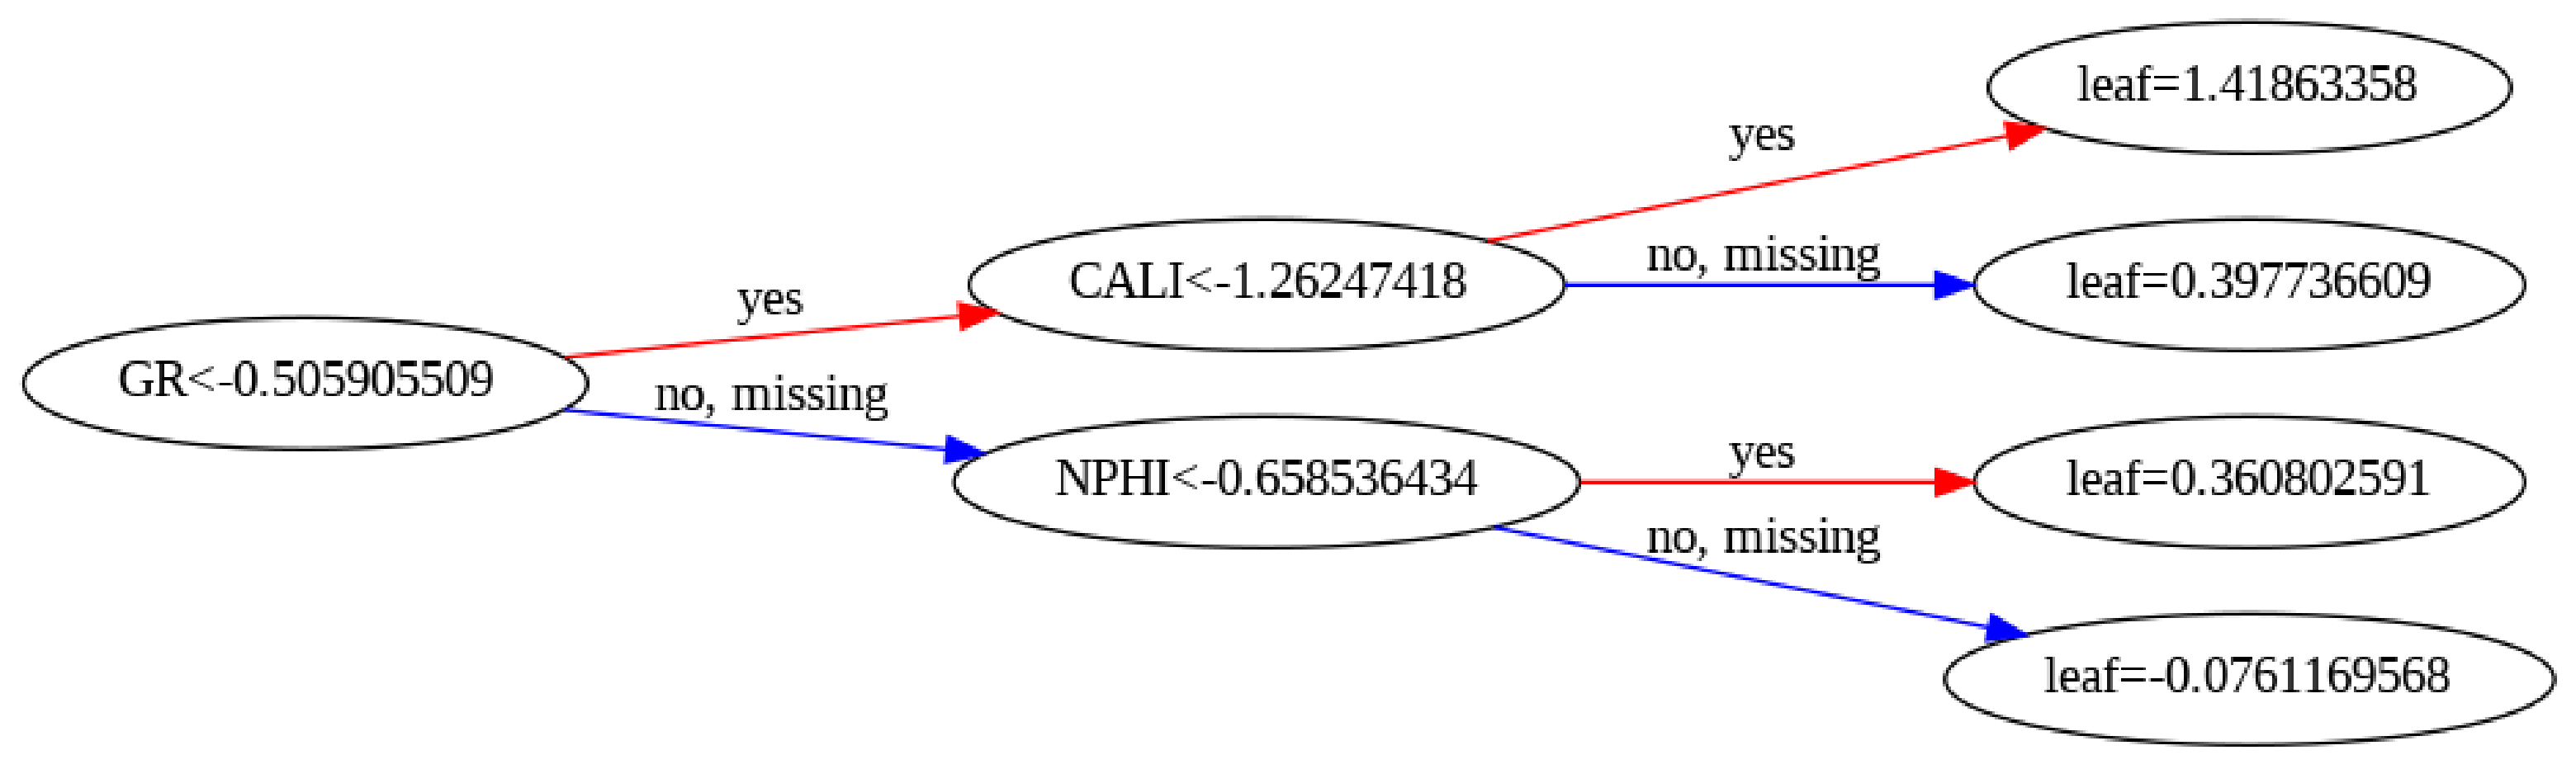

In [164]:
fig = plt.figure(figsize=(40, 20))
ax = fig.add_subplot(1, 1, 1)
plot_tree(model_tree, num_trees=0, rankdir='LR', ax=ax)

## Hyperparameter Tuning:

### Decision Tree Classifier Hyperparameter Tuning

In [ ]:
def max_depth_error(md):
    model = DecisionTreeClassifier(max_depth=md, random_state=42)
    model.fit(x_train, y_train)
    train_acc = 1 - model.score(x_train, y_train)
    val_acc = 1 - model.score(x_val, y_val)
    return {'Max Depth': md, 'Training Error': train_acc, 'Validation Error': val_acc}

In [ ]:
errors_df = pd.DataFrame([max_depth_error(md) for md in range(3, 18, 2)])

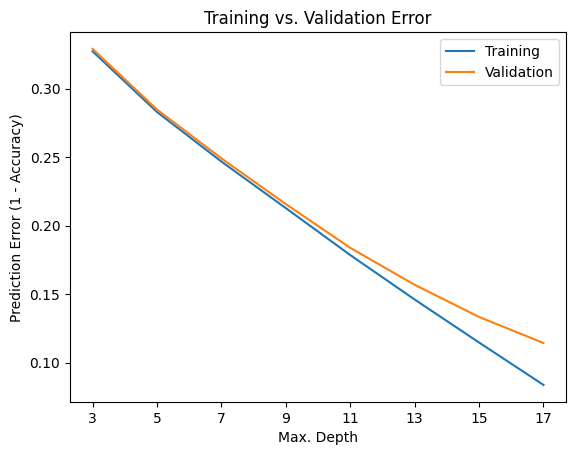

In [ ]:
plt.figure()
plt.plot(errors_df['Max Depth'], errors_df['Training Error'])
plt.plot(errors_df['Max Depth'], errors_df['Validation Error'])
plt.title('Training vs. Validation Error')
plt.xticks(range(3,18, 2))
plt.xlabel('Max. Depth')
plt.ylabel('Prediction Error (1 - Accuracy)')
plt.legend(['Training', 'Validation']);

### Random Forest Hyperparameter Tuning:

In [ ]:
def max_depth_error_ranfor(md):

        model = RandomForestClassifier(n_jobs=-1,
                                       random_state=42,
                                       n_estimators=700,
                                       max_features=7,
                                       max_depth=md)
        model.fit(X_cudf, Y_cudf)
        train_acc = 1 - model.score(x_train, y_train)
        val_acc = 1 - model.score(x_val, y_val)
        return {'Max Depth': md, 'Training Error': train_acc, 'Validation Error': val_acc}

In [ ]:
errors_df = pd.DataFrame([max_depth_error_ranfor(md) for md in range(3, 18, 2)])

In [ ]:
plt.figure()
plt.plot(errors_df['Max Depth'], errors_df['Training Error'])
plt.plot(errors_df['Max Depth'], errors_df['Validation Error'])
plt.title('Training vs. Validation Error')
plt.xticks(range(3,18, 2))
plt.xlabel('Max. Depth')
plt.ylabel('Prediction Error (1 - Accuracy)')
plt.legend(['Training', 'Validation']);

### k-Fold Cross Validation:

In [ ]:
from sklearn.model_selection import KFold, cross_val_score

cv = KFold(n_splits=10, random_state=1, shuffle=True)

In [ ]:
model_xgboost2

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=13, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=350, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [ ]:
scores = cross_val_score(model_xgboost2, x_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)

In [ ]:
from numpy import std
from numpy import mean
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Accuracy: 0.954 (0.001)


# Evaluation Matrices

## Evaluation of Training Dataset:

### Accuracy Score:

In [165]:
dtree_train_accuracy = model_dtree.score(x_train, y_train)
dtree2_train_accuracy = model_dtree2.score(x_train, y_train)
rforest_train_accuracy = model_rforest.score(x_train, y_train)
xgboost_train_accuracy = model_xgboost.score(x_train, y_train)
xgboost2_train_accuracy = model_xgboost2.score(x_train, y_train)
catboost_train_accuracy = model_catboost.score(x_train, y_train)

## Evaluation of Validation Dataset:

In [166]:
from sklearn.metrics import f1_score, recall_score, precision_score, jaccard_score

### Accuracy Score:

In [167]:
dtree_score = model_dtree.score(x_val, y_val)
dtree2_score = model_dtree2.score(x_val, y_val)
rforest_score = model_rforest.score(x_val, y_val)
xgboost_score = model_xgboost.score(x_val, y_val)
xgboost2_score = model_xgboost2.score(x_val, y_val)
catboost_score = model_catboost.score(x_val, y_val)

### F1 Score:

In [168]:
dtree_f1_score = f1_score(model_dtree.predict(x_val), y_val, average='macro')
dtree2_f1_score = f1_score(model_dtree2.predict(x_val), y_val, average='macro')
rforest_f1_score = f1_score(model_rforest.predict(x_val), y_val, average='macro')
xgboost_f1_score = f1_score(model_xgboost.predict(x_val), y_val, average='macro')
xgboost2_f1_score = f1_score(model_xgboost2.predict(x_val), y_val, average='macro')
catboost_f1_score = f1_score(model_catboost.predict(x_val), y_val, average='macro')

### Recall Score:

In [169]:
dtree_recall_score = recall_score(model_dtree.predict(x_val), y_val, average='macro')
dtree2_recall_score = recall_score(model_dtree2.predict(x_val), y_val, average='macro')
rforest_recall_score = recall_score(model_rforest.predict(x_val), y_val, average='macro')
xgboost_recall_score = recall_score(model_xgboost.predict(x_val), y_val, average='macro')
xgboost2_recall_score = recall_score(model_xgboost2.predict(x_val), y_val, average='macro')
catboost_recall_score = recall_score(model_catboost.predict(x_val), y_val, average='macro')

### Precision Score:

In [170]:
dtree_precision_score = precision_score(model_dtree.predict(x_val), y_val, average='macro')
dtree2_precision_score = precision_score(model_dtree2.predict(x_val), y_val, average='macro')
xgboost_precision_score = precision_score(model_xgboost.predict(x_val), y_val, average='macro')
rforest_score_precision_score = precision_score(model_rforest.predict(x_val), y_val, average='macro')
xgboost2_precision_score = precision_score(model_xgboost2.predict(x_val), y_val, average='macro')
catboost_precision_score = precision_score(model_catboost.predict(x_val), y_val, average='macro')

### Jaccard Score:

In [171]:
dtree_jaccard_score = jaccard_score(model_dtree.predict(x_val), y_val, average='macro')
dtree2_jaccard_score = jaccard_score(model_dtree2.predict(x_val), y_val, average='macro')
xgboost_jaccard_score = jaccard_score(model_xgboost.predict(x_val), y_val, average='macro')
rforest_jaccard_score = jaccard_score(model_rforest.predict(x_val), y_val, average='macro')
xgboost2_jaccard_score = jaccard_score(model_xgboost2.predict(x_val), y_val, average='macro')
catboost_jaccard_score = jaccard_score(model_catboost.predict(x_val), y_val, average='macro')

## Evaluation of HiddenTest Dataset:

### Accuracy Score:

In [172]:
dtree_test_score = model_dtree.score(x_hiddentest, y_hiddentest)
dtree2_test_score = model_dtree2.score(x_hiddentest, y_hiddentest)
rforest_test_score = model_rforest.score(x_hiddentest, y_hiddentest)
xgboost_test_score = model_xgboost.score(x_hiddentest, y_hiddentest)
xgboost2_test_score = model_xgboost2.score(x_hiddentest, y_hiddentest)
catboost_test_score = model_catboost.score(x_hiddentest, y_hiddentest)

# Modelling Results

## Results of Training Dataset

### Accuracy Score:

In [173]:
results_accuracy_train = pd.DataFrame({
    'Model':['Decison Tree',
             'Decision Tree_2',
             'Random Forest',
             'XGboost',
             'XGboost2',
             'Catboost'
            ],
    'Accuracy_Score':[
                        dtree_train_accuracy,
                        dtree2_train_accuracy,
                        rforest_train_accuracy,
                        xgboost_train_accuracy,
                        xgboost2_train_accuracy,
                        catboost_train_accuracy
                    ]})

sorted_result_accuracy_train = results_accuracy_train.sort_values(by='Accuracy_Score', ascending=False).reset_index(drop=True)
sorted_result_accuracy_train

,Model,Accuracy_Score
0,Decison Tree,1.000000
1,XGboost2,0.999973
2,XGboost,0.964840
3,Catboost,0.905620
4,Random Forest,0.865783
5,Decision Tree_2,0.851547


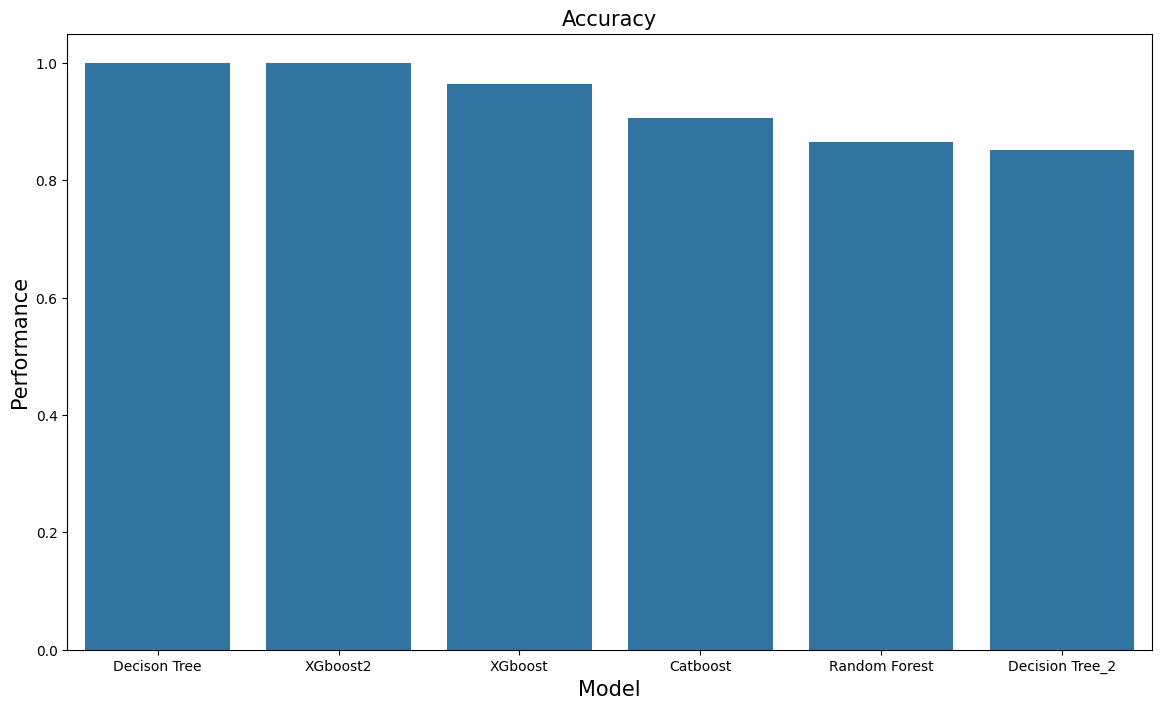

In [174]:
f, ax = plt.subplots(figsize=(14,8))
plt.xticks(rotation='horizontal')
sns.barplot(x=sorted_result_accuracy_train['Model'], y=sorted_result_accuracy_train['Accuracy_Score'])
plt.xlabel('Model', fontsize=15)
plt.ylabel('Performance', fontsize=15)
plt.title('Accuracy', fontsize=15)
plt.show()

## Results of Validation Dataset

### Accuracy Score:

In [175]:
results_accuracy_val = pd.DataFrame({
    'Model':['Decison Tree',
             'Decision Tree_2',
             'Random Forest',
             'XGboost',
             'XGboost2',
             'Catboost'
            ],
    'Accuracy_Score':[
                        dtree_score,
                        dtree2_score,
                        rforest_score,
                        xgboost_score,
                        xgboost2_score,
                        catboost_score
                    ]})

sorted_result_accuracy_val = results_accuracy_val.sort_values(by='Accuracy_Score', ascending=False).reset_index(drop=True)
sorted_result_accuracy_val

,Model,Accuracy_Score
0,XGboost2,0.955737
1,XGboost,0.938933
2,Decison Tree,0.910129
3,Catboost,0.899308
4,Random Forest,0.856181
5,Decision Tree_2,0.842168


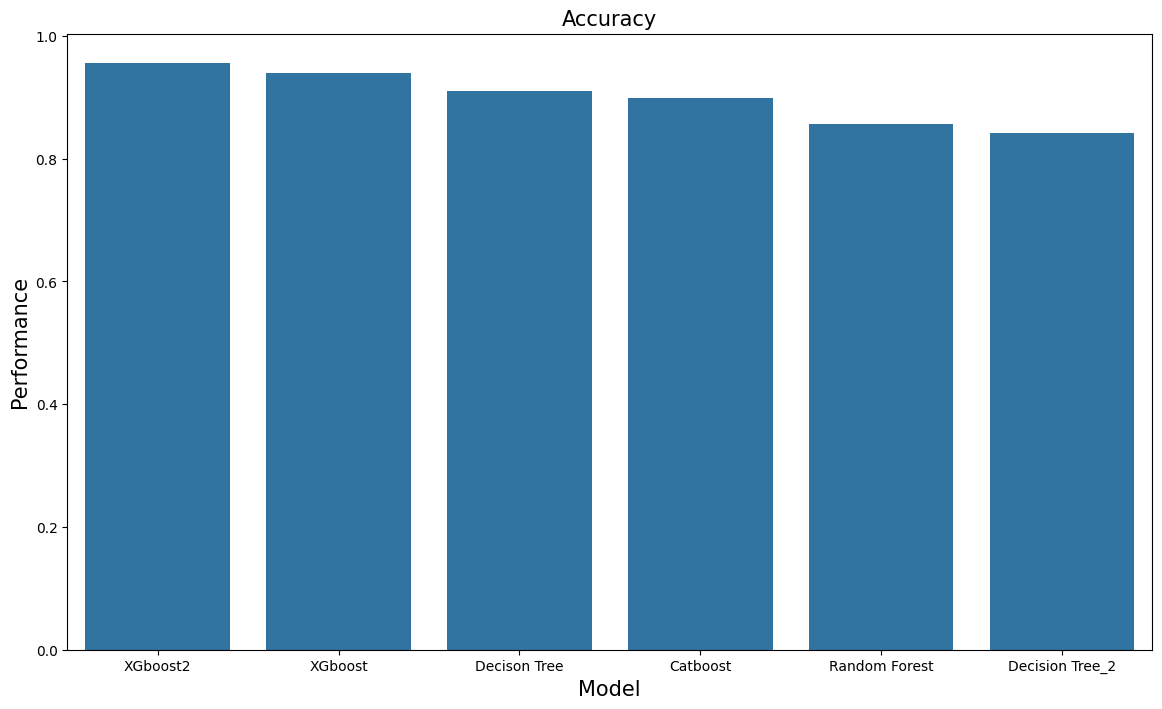

In [176]:
f, ax = plt.subplots(figsize=(14,8))
plt.xticks(rotation='horizontal')
sns.barplot(x=sorted_result_accuracy_val['Model'], y=sorted_result_accuracy_val['Accuracy_Score'])
plt.xlabel('Model', fontsize=15)
plt.ylabel('Performance', fontsize=15)
plt.title('Accuracy', fontsize=15)
plt.show()

### F1 Score:

In [177]:
results_f1 = pd.DataFrame({
    'Model':['Decison Tree',
             'Decision Tree_2',
             'Random Forest',
             'XGboost',
             'XGboost2',
             'Catboost'
            ],
    'F1_Score':[
                        dtree_f1_score,
                        dtree2_f1_score,
                        rforest_f1_score,
                        xgboost_f1_score,
                        xgboost2_f1_score,
                        catboost_f1_score]})

sorted_result_f1 = results_f1.sort_values(by='F1_Score', ascending=False).reset_index(drop=True)
sorted_result_f1

,Model,F1_Score
0,XGboost2,0.916574
1,XGboost,0.886842
2,Catboost,0.837577
3,Decison Tree,0.826333
4,Random Forest,0.683033
5,Decision Tree_2,0.633494


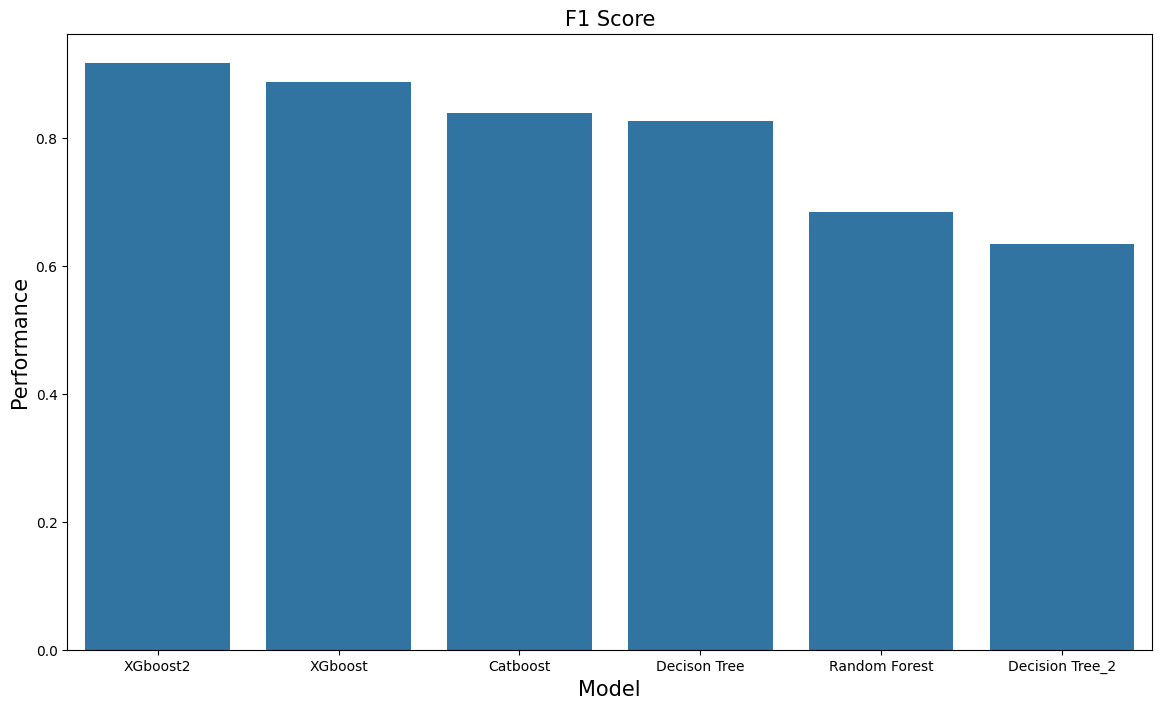

In [178]:
f, ax = plt.subplots(figsize=(14,8))
plt.xticks(rotation='horizontal')
sns.barplot(x=sorted_result_f1['Model'], y=sorted_result_f1['F1_Score'])
plt.xlabel('Model', fontsize=15)
plt.ylabel('Performance', fontsize=15)
plt.title('F1 Score', fontsize=15)
plt.show()

### Recall Score:

In [179]:
results_recall = pd.DataFrame({
    'Model':['Decison Tree',
             'Decision Tree_2',
             'Random Forest',
             'XGboost',
             'XGboost2',
             'Catboost'
            ],
    'Recall_Score':[
                        dtree_recall_score,
                        dtree2_recall_score,
                        rforest_recall_score,
                        xgboost_recall_score,
                        xgboost2_recall_score,
                        catboost_recall_score]})

sorted_result_recall = results_recall.sort_values(by='Recall_Score', ascending=False).reset_index(drop=True)
sorted_result_recall

,Model,Recall_Score
0,XGboost2,0.946375
1,XGboost,0.928287
2,Random Forest,0.902286
3,Catboost,0.894416
4,Decison Tree,0.831476
5,Decision Tree_2,0.812054


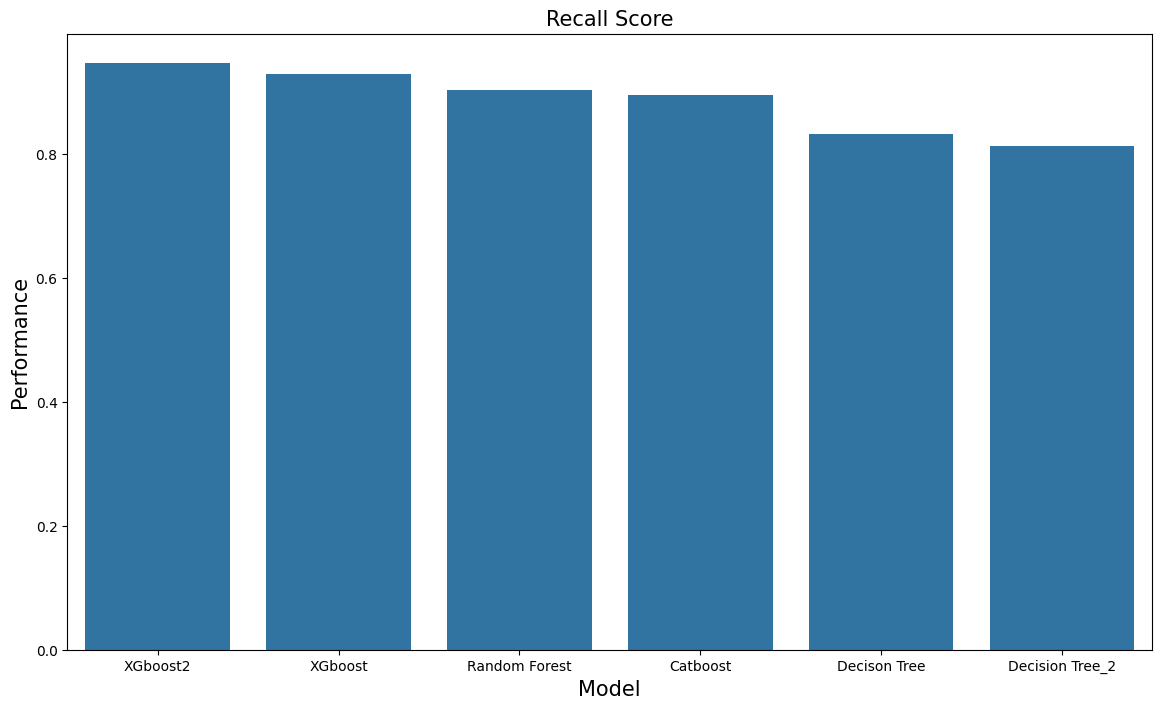

In [180]:
f, ax = plt.subplots(figsize=(14,8))
plt.xticks(rotation='horizontal')
sns.barplot(x=sorted_result_recall['Model'], y=sorted_result_recall['Recall_Score'])
plt.xlabel('Model', fontsize=15)
plt.ylabel('Performance', fontsize=15)
plt.title('Recall Score', fontsize=15)
plt.show()

### Precision Score:

In [181]:
results_precision = pd.DataFrame({
    'Model':['Decison Tree',
             'Decision Tree_2',
             'Random Forest',
             'XGboost',
             'XGboost2',
             'Catboost'
            ],
    'Precision_Score':[
                        dtree_precision_score,
                        dtree2_precision_score,
                        rforest_score_precision_score,
                        xgboost_precision_score,
                        xgboost2_precision_score,
                        catboost_precision_score]})

sorted_result_precision = results_precision.sort_values(by='Precision_Score', ascending=False).reset_index(drop=True)
sorted_result_precision

,Model,Precision_Score
0,XGboost2,0.895285
1,XGboost,0.858809
2,Decison Tree,0.821519
3,Catboost,0.801627
4,Random Forest,0.608298
5,Decision Tree_2,0.581085


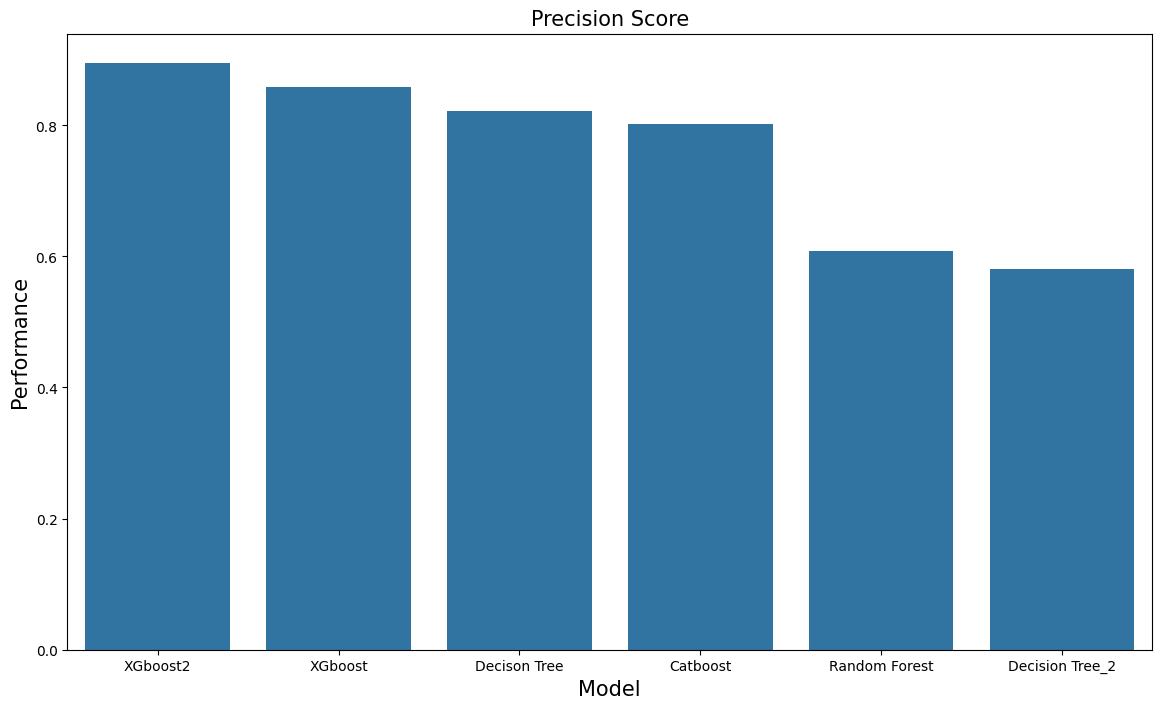

In [182]:
f, ax = plt.subplots(figsize=(14,8))
plt.xticks(rotation='horizontal')
sns.barplot(x=sorted_result_precision['Model'], y=sorted_result_precision['Precision_Score'])
plt.xlabel('Model', fontsize=15)
plt.ylabel('Performance', fontsize=15)
plt.title('Precision Score', fontsize=15)
plt.show()

### Jaccard Score:

In [183]:
results_jaccard = pd.DataFrame({
    'Model':['Decison Tree',
             'Decision Tree_2',
             'Random Forest',
             'XGboost',
             'XGboost2',
             'Catboost'
            ],
    'Jaccard_Score':[dtree_jaccard_score,
                     dtree2_jaccard_score,
                     rforest_jaccard_score,
                     xgboost_jaccard_score,
                     xgboost2_jaccard_score,
                     catboost_jaccard_score]})

sorted_result_jaccard = results_jaccard.sort_values(by='Jaccard_Score', ascending=False).reset_index(drop=True)
sorted_result_jaccard

,Model,Jaccard_Score
0,XGboost2,0.857745
1,XGboost,0.812966
2,Catboost,0.744848
3,Decison Tree,0.729128
4,Random Forest,0.565219
5,Decision Tree_2,0.517703


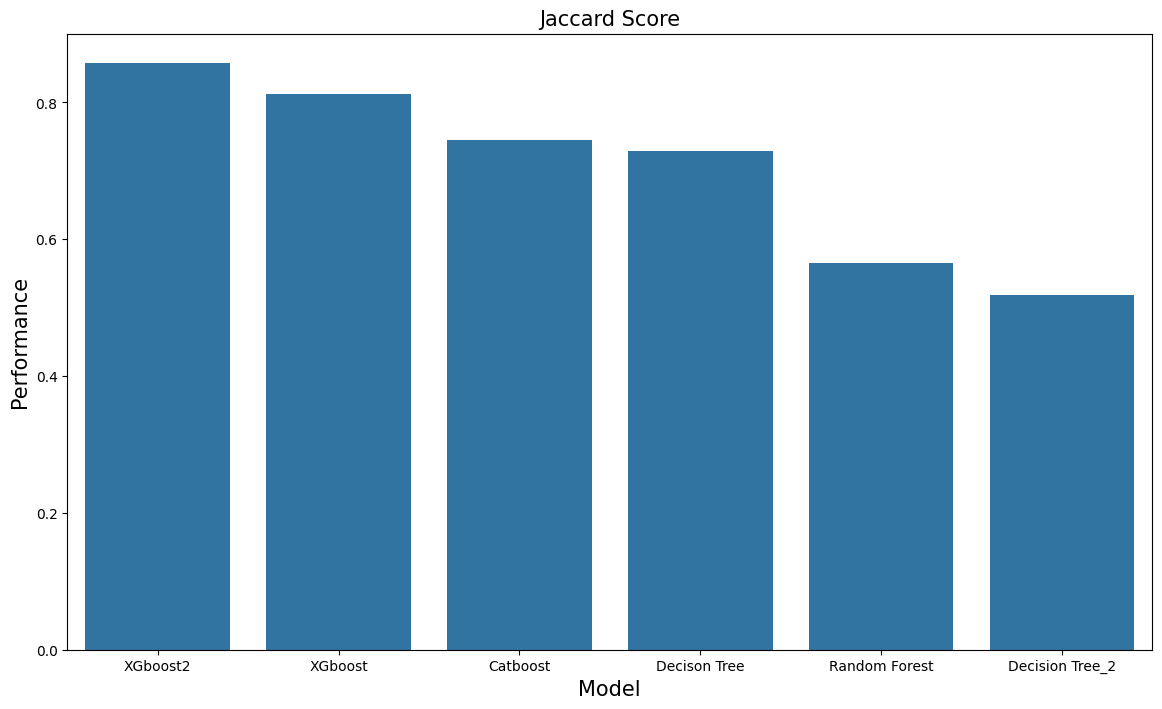

In [184]:
f, ax = plt.subplots(figsize=(14,8))
plt.xticks(rotation='horizontal')
sns.barplot(x=sorted_result_jaccard['Model'], y=sorted_result_jaccard['Jaccard_Score'])
plt.xlabel('Model', fontsize=15)
plt.ylabel('Performance', fontsize=15)
plt.title('Jaccard Score', fontsize=15)
plt.show()

## Results of HiddenTest Dataset

### Accuracy Score:

In [185]:
results_hiddentest_accuracy = pd.DataFrame({
    'Model':['Decison Tree',
             'Decision Tree_2',
             'Random Forest',
             'XGboost',
             'XGboost2',
             'Catboost'
            ],
    'Accuracy_Score':[ dtree_test_score,
                        dtree2_test_score,
                        rforest_test_score,
                        xgboost_test_score,
                        xgboost2_test_score,
                        catboost_test_score]})

sorted_result_hiddentest_accuracy = results_hiddentest_accuracy.sort_values(by='Accuracy_Score', ascending=False).reset_index(drop=True)
sorted_result_hiddentest_accuracy

,Model,Accuracy_Score
0,XGboost,0.757715
1,XGboost2,0.750010
2,Random Forest,0.726211
3,Catboost,0.706325
4,Decision Tree_2,0.686087
5,Decison Tree,0.594524


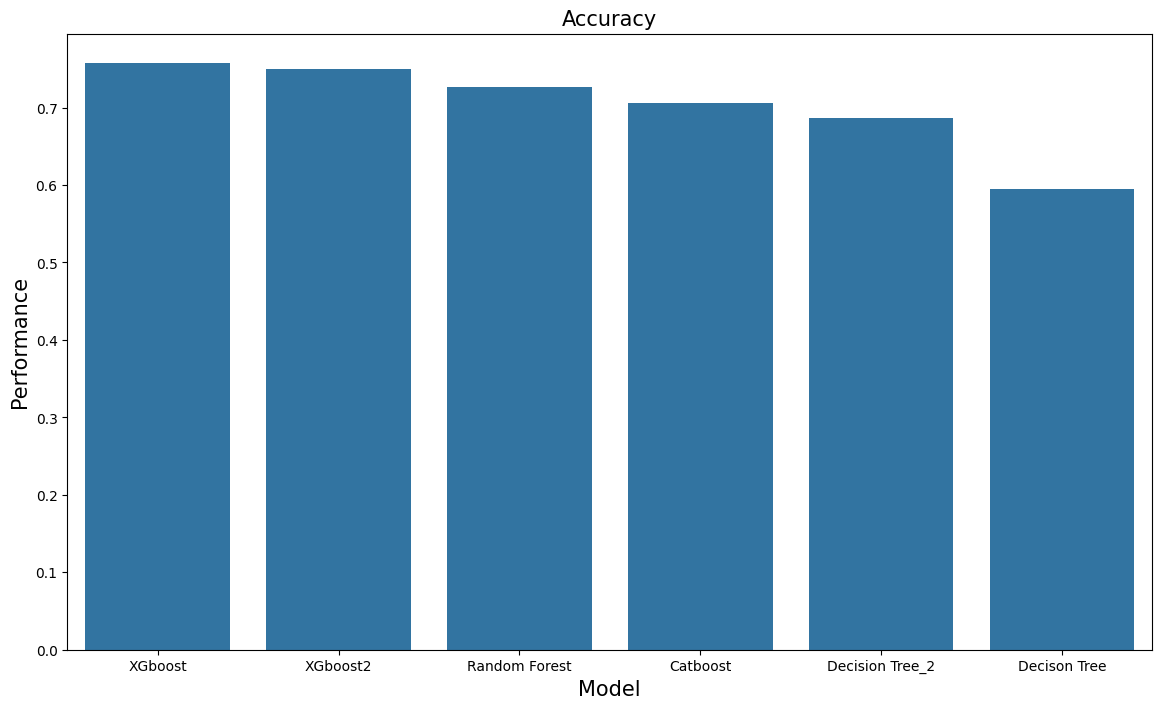

In [186]:
f, ax = plt.subplots(figsize=(14,8))
plt.xticks(rotation='horizontal')
sns.barplot(x=sorted_result_hiddentest_accuracy['Model'], y=sorted_result_hiddentest_accuracy['Accuracy_Score'])
plt.xlabel('Model', fontsize=15)
plt.ylabel('Performance', fontsize=15)
plt.title('Accuracy', fontsize=15)
plt.show()

# Test Dataset:

In [187]:
cols_to_drop = ['WELL','RSHA', 'GROUP', 'FORMATION','X_LOC', 'Y_LOC', 'Z_LOC','MUDWEIGHT', 'DCAL', 'RXO', 'RMIC', 'DTS', 'BS', 'ROPA', 'SGR']

x_test = df_test.drop(columns=df_test.columns.intersection(cols_to_drop), axis=1)

In [188]:
x_test.columns

Index(['DEPTH_MD', 'CALI', 'RMED', 'RDEP', 'RHOB', 'GR', 'NPHI', 'PEF', 'DTC',
       'SP', 'ROP', 'DRHO'],
      dtype='object')

In [189]:
from sklearn.impute import KNNImputer
import numpy as np

skew_values = x_test.skew()

mean_impute_cols = []
median_impute_cols = []
knn_impute_cols = []

for col, skew in skew_values.items():
    if -1 <= skew <= 1:
        mean_impute_cols.append(col)
    elif -3 <= skew < -1 or 1 < skew <= 3:
        median_impute_cols.append(col)
    else:
        knn_impute_cols.append(col)

print("Mean Imputation Columns:", mean_impute_cols)
print("Median Imputation Columns:", median_impute_cols)
print("KNN Imputation Columns:", knn_impute_cols)


Mean Imputation Columns: ['DEPTH_MD', 'CALI', 'RHOB', 'NPHI', 'DTC', 'SP']
Median Imputation Columns: ['GR']
KNN Imputation Columns: ['RMED', 'RDEP', 'PEF', 'ROP', 'DRHO']


In [190]:
import pandas as pd
import cudf
import cupy as cp
from cuml.neighbors import KNeighborsRegressor
from sklearn.impute import SimpleImputer

def mean_median_impute_cpu(df, mean_cols, median_cols):
    """
    Performs mean and median imputation using CPU-based SimpleImputer.
    """
    df_imputed = df.copy()

    # 🟢 Mean Imputation (CPU)
    if mean_cols:
        mean_imputer = SimpleImputer(strategy="mean")
        df_imputed[mean_cols] = mean_imputer.fit_transform(df[mean_cols])

    # 🟠 Median Imputation (CPU)
    if median_cols:
        median_imputer = SimpleImputer(strategy="median")
        df_imputed[median_cols] = median_imputer.fit_transform(df[median_cols])

    return df_imputed


def knn_impute_gpu(df, knn_cols, n_neighbors=3):
    """
    Performs KNN imputation on specified columns using cuML (GPU-accelerated).
    """
    df_filled = df.copy()
    gdf = cudf.DataFrame.from_pandas(df)  # Convert pandas DataFrame to cuDF

    for col in knn_cols:
        missing_mask = gdf[col].isna()
        if missing_mask.sum() == 0:
            continue  # Skip if no missing values

        # Instead of dropping rows, use only the columns needed for KNN
        known_data = gdf[~missing_mask][[col] + [c for c in gdf.columns if c != col and c not in knn_cols]].dropna()
        unknown_data = gdf[missing_mask][[c for c in gdf.columns if c != col and c not in knn_cols]].dropna()

        # Ensure that known_data and unknown_data have matching number of features:
        num_features_known = known_data.shape[1] - 1  # Exclude the target column
        num_features_unknown = unknown_data.shape[1]

        # If num_features don't match, skip imputation for this column:
        if num_features_known != num_features_unknown:
            print(f"Skipping imputation for column '{col}' due to feature mismatch.")
            continue

        # Train KNN on available data using pandas DataFrames:
        knn = KNeighborsRegressor(n_neighbors=n_neighbors, metric="euclidean")
        knn.fit(known_data[[c for c in known_data.columns if c != col]].to_pandas().values,
                known_data[col].to_pandas().values)

        # Predict missing values:
        imputed_values = knn.predict(unknown_data.to_pandas().values)

        # Get the indices of missing values in the original pandas DataFrame:
        missing_indices = df[df[col].isnull()].index

        # Assign back to DataFrame using missing_indices and imputed_values:
        df_filled.loc[missing_indices, col] = imputed_values

    return df_filled  # Convert back to pandas


# 🏗 **Apply Imputations Using Precomputed Column Lists**
x_test = mean_median_impute_cpu(x_test, mean_impute_cols, median_impute_cols)
x_test = knn_impute_gpu(x_test, knn_impute_cols)

# ✅ **Check for Remaining NaN Values**
missing_after_imputation = x_test.isnull().sum().sum()
print(f"Total missing values after imputation: {missing_after_imputation}")

Total missing values after imputation: 0


In [91]:
# x_test['RHOB'] = x_test['RHOB'].values - x_test['DRHO'].values

In [92]:
# x_test = x_test.drop(columns=['DRHO'])

In [93]:
# knn_impute_cols = [col for col in knn_impute_cols if col != 'DRHO']

In [191]:
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer

# 🟩 Apply StandardScaler to columns with skew in [-1, 1]
scaler = StandardScaler()
x_test[mean_impute_cols] = scaler.fit_transform(x_test[mean_impute_cols])

# 🟩 Apply RobustScaler to columns with high skewness
robust_scaler = RobustScaler()
x_test[median_impute_cols] = robust_scaler.fit_transform(x_test[median_impute_cols])

# 🟩 Apply PowerTransformer (Yeo-Johnson) to highly skewed columns
power_transformer = PowerTransformer(method='yeo-johnson')
x_test[knn_impute_cols] = power_transformer.fit_transform(x_test[knn_impute_cols])

In [192]:
y_predtest = model_xgboost2.predict(x_test)
y_predtest

array([2, 2, 2, ..., 1, 1, 1])

In [193]:
df_test['WELL'].unique()

array(['15/9-14', '25/10-10', '25/11-24', '25/5-3', '29/3-1',
       '34/10-16 R', '34/3-3 A', '34/6-1 S', '35/6-2 S', '35/9-8'],
      dtype=object)

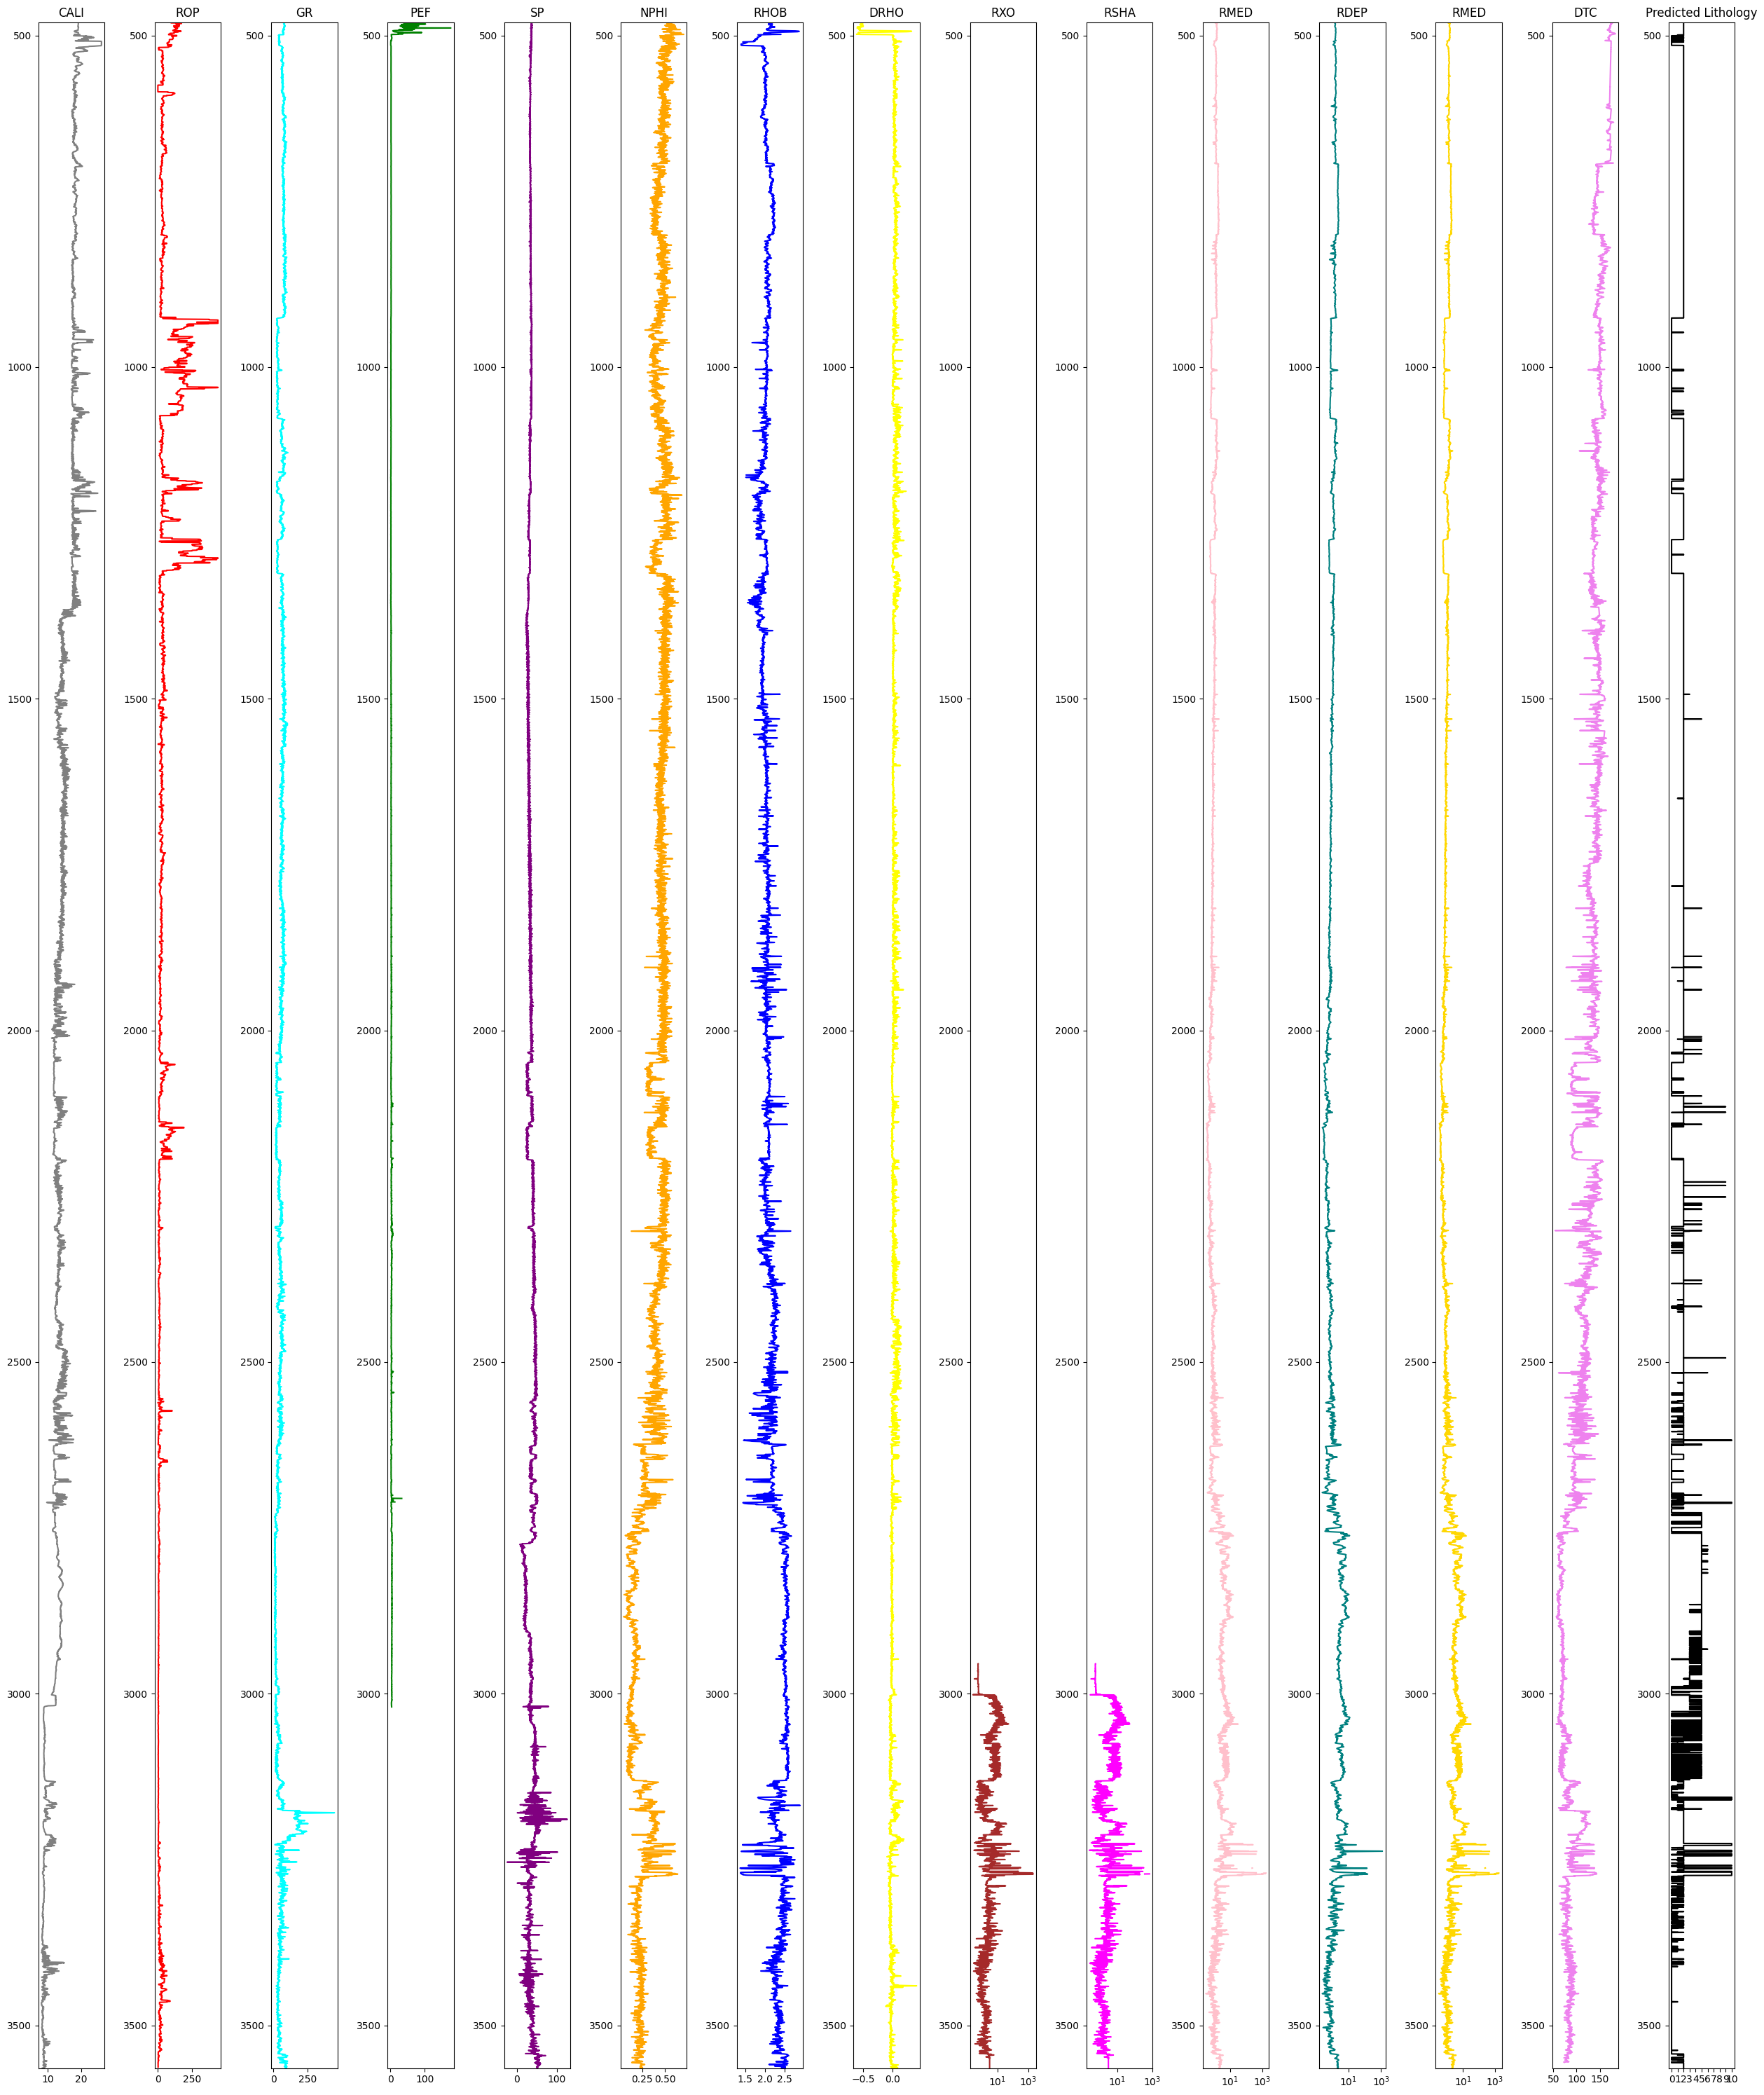

In [194]:
import matplotlib.pyplot as plt

logs = ['CALI', 'ROP', 'GR', 'PEF', 'SP', 'NPHI', 'RHOB', 'DRHO', 'RXO', 'RSHA', 'RMED', 'RDEP', 'RMED', 'DTC']
colors = ['grey', 'red', 'cyan', 'green', 'purple', 'orange', 'blue', 'yellow', 'brown', 'magenta', 'pink', 'teal', 'gold', 'violet']

# Create subplots: one for each log + one for predicted lithology
fig, ax = plt.subplots(nrows=1, ncols=len(logs)+1, figsize=(25, 30))

# Filter predictions for the specific well
well_name = '15/9-14'  # Choose the desired well name
well_indices = df_test[df_test['WELL'] == well_name].index
well_pred = y_predtest[well_indices]  # Select predictions for this well


well_data = df_test[df_test['WELL'] == well_name]
depth = well_data['DEPTH_MD'].values

for i in range(len(logs)):
    log_data = well_data[logs[i]]
    if logs[i] in ['RDEP', 'RMED', 'RSHA', 'RXO']:
        ax[i].semilogx(log_data, depth, color=colors[i])
    else:
        ax[i].plot(log_data, depth, color=colors[i])

    ax[i].set_title(logs[i])
    ax[i].invert_yaxis()
    ax[i].set_ylim(depth.max(), depth.min())

# Plot predicted lithology for the specific well
ax[-1].plot(well_pred, depth, color='black')  # Use well_pred here
ax[-1].set_title("Predicted Lithology")
ax[-1].invert_yaxis()
ax[-1].set_ylim(depth.max(), depth.min())
ax[-1].set_xticks(np.arange(11))
ax[-1].set_xlim(-0.5, 11 - 0.5)

plt.tight_layout()
plt.show()

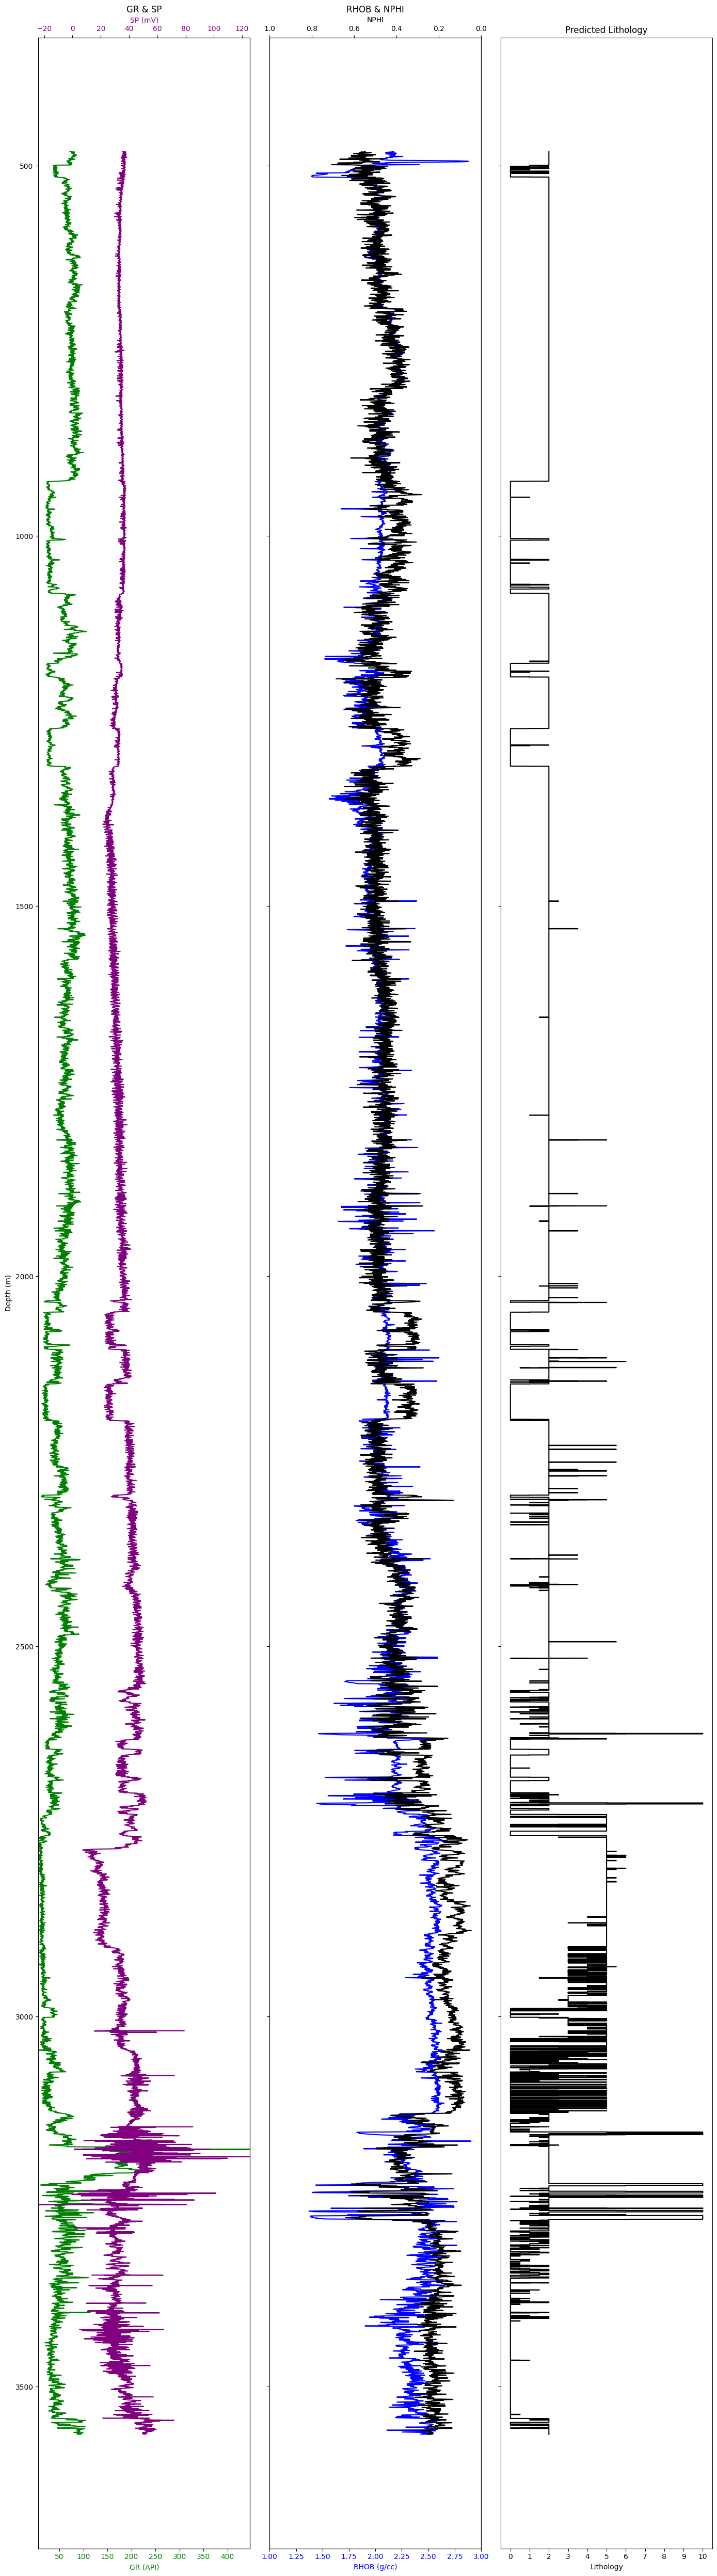

In [195]:
import matplotlib.pyplot as plt

# Filter data
well_name = '15/9-14'
well_data = df_test[df_test['WELL'] == well_name]
depth = well_data['DEPTH_MD'].values
gr = well_data['GR'].values
sp = well_data['SP'].values
nphi = well_data['NPHI'].values
rhob = well_data['RHOB'].values
well_indices = df_test[df_test['WELL'] == well_name].index
lith = y_predtest[well_indices]

# Set up 3 tracks
fig, axes = plt.subplots(ncols=3, figsize=(14, 50), sharey=True)

# Track 1: GR and SP on different axes
ax1 = axes[0]
ax1.plot(gr, depth, color='green', label='GR')
ax1.set_xlim(gr.min(), gr.max())  # GR decreases to left
ax1.set_xlabel("GR (API)", color='green')
ax1.tick_params(axis='x', labelcolor='green')
ax1.set_ylabel("Depth (m)")
ax1.invert_yaxis()
ax1.set_title("GR & SP")

ax1b = ax1.twiny()  # Secondary x-axis for SP
ax1b.plot(sp, depth, color='purple', label='SP')
ax1b.set_xlim(sp.min(), sp.max())  # SP decreases to left
ax1b.set_xlabel("SP (mV)", color='purple')
ax1b.tick_params(axis='x', labelcolor='purple')

# Track 2: RHOB and NPHI with opposing axes
ax2 = axes[1]
ax2.plot(rhob, depth, color='blue', label='RHOB')
ax2.set_xlim(1.0, 3.0)
ax2.set_xlabel("RHOB (g/cc)", color='blue')
ax2.tick_params(axis='x', labelcolor='blue')
ax2.set_title("RHOB & NPHI")

ax2b = ax2.twiny()  # Twin axis for NPHI
ax2b.plot(nphi, depth, color='black', label='NPHI')
ax2b.set_xlim(1.0, 0.0)  # NPHI reversed (right-to-left)
ax2b.set_xlabel("NPHI", color='black')
ax2b.tick_params(axis='x', labelcolor='black')

# Track 3: Lithology
axes[2].plot(lith, depth, drawstyle='steps-mid', color='black')
axes[2].set_xlim(-0.5, 10.5)
axes[2].set_xlabel("Lithology")
axes[2].set_title("Predicted Lithology")
axes[2].set_xticks(range(11))

plt.tight_layout()
plt.show()


#  Conclusions:

# Future Work:

*   Better Hyperparameters for CatBoost Model.
*    Apply deep learning methodology to predict the lithology using the same dataset.

# References:

COMPETITION: https://thinkonward.com/app/c/challenges/force-well-logs

DATASET: https://www.kaggle.com/code/manishgarje/lithology-prediction#3.-Preparing-the-Petrophysical-Logs-Dataset